In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

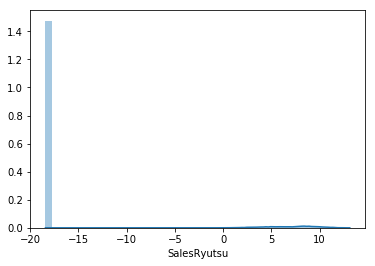

In [3]:
sns.distplot(np.log(df_train_Y['SalesRyutsu'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesRyutsu']:
    df_train_Y['SalesRyutsu_log'] = df_train_Y['SalesRyutsu'].apply(log)
    df_val_Y['SalesRyutsu_log'] = df_val_Y['SalesRyutsu'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesRyutsu_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesRyutsu_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.027861832194435616, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.0689315657146182e-05, 'lambda': 0.0007835237441939999, 'learning_rate': 0.07500000000000001, 'max_depth': 5, 'min_child_weight': 4.828688001001624, 'n_estimators': 548.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:17.0421	eval-rmse:16.255                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.8329	eval-rmse:15.1926                                                                               

[2]	train-rmse:14.7228	eval-rmse:14.2179                                                         

[62]	train-rmse:3.66921	eval-rmse:5.83857                                                                              

[63]	train-rmse:3.66723	eval-rmse:5.83824                                                                              

[64]	train-rmse:3.66478	eval-rmse:5.83779                                                                              

[65]	train-rmse:3.66255	eval-rmse:5.83651                                                                              

[66]	train-rmse:3.6592	eval-rmse:5.83585                                                                               

[67]	train-rmse:3.65638	eval-rmse:5.83578                                                                              

[68]	train-rmse:3.65459	eval-rmse:5.83502                                                                              

[69]	train-rmse:3.6514	eval-rmse:5.83276                                                                               

[70]	train-rmse:3.64871	eval-rms

[31]	train-rmse:4.82194	eval-rmse:6.61965                                                                              

[32]	train-rmse:4.68928	eval-rmse:6.54711                                                                              

[33]	train-rmse:4.56484	eval-rmse:6.48018                                                                              

[34]	train-rmse:4.44859	eval-rmse:6.4183                                                                               

[35]	train-rmse:4.34067	eval-rmse:6.36246                                                                              

[36]	train-rmse:4.24109	eval-rmse:6.31355                                                                              

[37]	train-rmse:4.14796	eval-rmse:6.26905                                                                              

[38]	train-rmse:4.06325	eval-rmse:6.23355                                                                              

[39]	train-rmse:3.98387	eval-rms

[98]	train-rmse:2.9161	eval-rmse:5.86692                                                                               

[99]	train-rmse:2.91335	eval-rmse:5.86823                                                                              

loss: 100437132.42625068                                                                                               
Training with params:                                                                                                  
{'alpha': 0.6322101967693275, 'colsample_bytree': 0.9500000000000001, 'gamma': 1.586836246802511e-08, 'lambda': 0.0017851887621344196, 'learning_rate': 0.125, 'max_depth': 9, 'min_child_weight': 0.2963000473798433, 'n_estimators': 602.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.1448	eval-rmse:15.5001                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                

[3]	train-rmse:12.3288	eval-rmse:12.2513                                                                               

[4]	train-rmse:11.1965	eval-rmse:11.3145                                                                               

[5]	train-rmse:10.1866	eval-rmse:10.4929                                                                               

[6]	train-rmse:9.28711	eval-rmse:9.78584                                                                               

[7]	train-rmse:8.48495	eval-rmse:9.16723                                                                               

[8]	train-rmse:7.77235	eval-rmse:8.64348                                                                               

[9]	train-rmse:7.14101	eval-rmse:8.20283                                                                               

[10]	train-rmse:6.58244	eval-rmse:7.82607                                                                              

[11]	train-rmse:6.08815	eval-rms

[3]	train-rmse:12.389	eval-rmse:12.2322                                                                                

[4]	train-rmse:11.2752	eval-rmse:11.2972                                                                               

[5]	train-rmse:10.2833	eval-rmse:10.4791                                                                               

[6]	train-rmse:9.40243	eval-rmse:9.76488                                                                               

[7]	train-rmse:8.62133	eval-rmse:9.14423                                                                               

[8]	train-rmse:7.92938	eval-rmse:8.60549                                                                               

[9]	train-rmse:7.32272	eval-rmse:8.14543                                                                               

[10]	train-rmse:6.78978	eval-rmse:7.75688                                                                              

[11]	train-rmse:6.32521	eval-rms

{'alpha': 1.5147184591483149e-06, 'colsample_bytree': 0.75, 'gamma': 3.036717925901068e-08, 'lambda': 8.979621155080164e-06, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'min_child_weight': 0.1193710297485648, 'n_estimators': 812.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:15.7433	eval-rmse:15.1278                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.5518	eval-rmse:13.2288                                                                               

[2]	train-rmse:11.7108	eval-rmse:11.6463                                                                               

[3]	train-rmse:10.174	eval-rmse:10.3642                                                                     

[5]	train-rmse:3.53647	eval-rmse:6.28024                                                                               

[6]	train-rmse:3.31913	eval-rmse:6.25282                                                                               

[7]	train-rmse:3.19775	eval-rmse:6.2088                                                                                

[8]	train-rmse:3.1332	eval-rmse:6.21134                                                                                

[9]	train-rmse:3.07048	eval-rmse:6.20836                                                                               

[10]	train-rmse:3.04373	eval-rmse:6.20856                                                                              

[11]	train-rmse:3.02029	eval-rmse:6.23608                                                                              

[12]	train-rmse:2.96078	eval-rmse:6.2618                                                                               

[13]	train-rmse:2.92844	eval-rms

[35]	train-rmse:2.89496	eval-rmse:6.01639                                                                              

[36]	train-rmse:2.88741	eval-rmse:6.0171                                                                               

[37]	train-rmse:2.87746	eval-rmse:6.02171                                                                              

[38]	train-rmse:2.87107	eval-rmse:6.02485                                                                              

[39]	train-rmse:2.8599	eval-rmse:6.0279                                                                                

[40]	train-rmse:2.84772	eval-rmse:6.02994                                                                              

[41]	train-rmse:2.83767	eval-rmse:6.03626                                                                              

[42]	train-rmse:2.82922	eval-rmse:6.03093                                                                              

[43]	train-rmse:2.82306	eval-rms

[14]	train-rmse:6.7206	eval-rmse:7.70815                                                                               

[15]	train-rmse:6.37294	eval-rmse:7.4652                                                                               

[16]	train-rmse:6.05868	eval-rmse:7.25223                                                                              

[17]	train-rmse:5.77333	eval-rmse:7.06228                                                                              

[18]	train-rmse:5.51735	eval-rmse:6.8941                                                                               

[19]	train-rmse:5.28802	eval-rmse:6.74388                                                                              

[20]	train-rmse:5.08375	eval-rmse:6.61868                                                                              

[21]	train-rmse:4.90051	eval-rmse:6.50713                                                                              

[22]	train-rmse:4.73865	eval-rms

[1]	train-rmse:6.44976	eval-rmse:7.88205                                                                               

[2]	train-rmse:4.47986	eval-rmse:6.76434                                                                               

[3]	train-rmse:3.65032	eval-rmse:6.39005                                                                               

[4]	train-rmse:3.30969	eval-rmse:6.2966                                                                                

[5]	train-rmse:3.18262	eval-rmse:6.2598                                                                                

[6]	train-rmse:3.09243	eval-rmse:6.29223                                                                               

[7]	train-rmse:3.04217	eval-rmse:6.33213                                                                               

[8]	train-rmse:3.01165	eval-rmse:6.35753                                                                               

[9]	train-rmse:2.9578	eval-rmse:

[1]	train-rmse:9.59869	eval-rmse:9.91208                                                                               

[2]	train-rmse:7.23983	eval-rmse:8.08576                                                                               

[3]	train-rmse:5.73745	eval-rmse:7.04113                                                                               

[4]	train-rmse:4.80597	eval-rmse:6.46179                                                                               

[5]	train-rmse:4.27705	eval-rmse:6.16524                                                                               

[6]	train-rmse:3.98115	eval-rmse:6.02102                                                                               

[7]	train-rmse:3.81497	eval-rmse:5.96166                                                                               

[8]	train-rmse:3.71202	eval-rmse:5.96126                                                                               

[9]	train-rmse:3.66268	eval-rmse

[30]	train-rmse:3.35588	eval-rmse:6.00185                                                                              

[31]	train-rmse:3.35309	eval-rmse:6.00181                                                                              

[32]	train-rmse:3.34748	eval-rmse:6.00657                                                                              

[33]	train-rmse:3.34084	eval-rmse:6.01321                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.56814	eval-rmse:5.89982


loss: 2498485202.9531164                                                                                               
Training with params:                                                                                                  
{'alpha': 3.741054073455109e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00033824653788284726, 'lambd

[16]	train-rmse:3.8922	eval-rmse:5.97                                                                                  

[17]	train-rmse:3.88813	eval-rmse:5.97314                                                                              

[18]	train-rmse:3.88477	eval-rmse:5.97341                                                                              

[19]	train-rmse:3.88119	eval-rmse:5.97342                                                                              

[20]	train-rmse:3.87908	eval-rmse:5.97415                                                                              

[21]	train-rmse:3.87402	eval-rmse:5.96249                                                                              

[22]	train-rmse:3.87041	eval-rmse:5.958                                                                                

[23]	train-rmse:3.86615	eval-rmse:5.96248                                                                              

[24]	train-rmse:3.86253	eval-rms

[33]	train-rmse:3.68937	eval-rmse:5.91343                                                                              

[34]	train-rmse:3.68319	eval-rmse:5.91795                                                                              

[35]	train-rmse:3.67663	eval-rmse:5.91731                                                                              

[36]	train-rmse:3.6696	eval-rmse:5.91137                                                                               

[37]	train-rmse:3.66557	eval-rmse:5.91454                                                                              

[38]	train-rmse:3.6604	eval-rmse:5.91144                                                                               

[39]	train-rmse:3.65602	eval-rmse:5.91326                                                                              

[40]	train-rmse:3.65147	eval-rmse:5.91523                                                                              

[41]	train-rmse:3.64485	eval-rms

Training with params:                                                                                                  
{'alpha': 6.468964504396918e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 8.963344343897005e-05, 'lambda': 7.837307517354762e-05, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 1.0668981751824804, 'n_estimators': 778.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.4689	eval-rmse:14.0178                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.5121	eval-rmse:11.486                                                                                

[2]	train-rmse:9.28992	eval-rmse:9.64421                                                                     

[4]	train-rmse:3.40883	eval-rmse:6.20023                                                                               

[5]	train-rmse:3.22776	eval-rmse:6.16625                                                                               

[6]	train-rmse:3.12786	eval-rmse:6.17161                                                                               

[7]	train-rmse:3.08382	eval-rmse:6.15544                                                                               

[8]	train-rmse:3.05455	eval-rmse:6.16425                                                                               

[9]	train-rmse:3.02732	eval-rmse:6.17072                                                                               

[10]	train-rmse:3.00012	eval-rmse:6.18578                                                                              

[11]	train-rmse:2.94419	eval-rmse:6.18388                                                                              

[12]	train-rmse:2.89157	eval-rms

[35]	train-rmse:8.10371	eval-rmse:8.75383                                                                              

[36]	train-rmse:7.94126	eval-rmse:8.62958                                                                              

[37]	train-rmse:7.78332	eval-rmse:8.51098                                                                              

[38]	train-rmse:7.63052	eval-rmse:8.39703                                                                              

[39]	train-rmse:7.4828	eval-rmse:8.28747                                                                               

[40]	train-rmse:7.33828	eval-rmse:8.18087                                                                              

[41]	train-rmse:7.19906	eval-rmse:8.07834                                                                              

[42]	train-rmse:7.06339	eval-rmse:7.97924                                                                              

[43]	train-rmse:6.93242	eval-rms

{'alpha': 0.005068381736206219, 'colsample_bytree': 0.65, 'gamma': 1.7834021887727635e-05, 'lambda': 0.05681798524909085, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 8.596696752935273, 'n_estimators': 977.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:17.4755	eval-rmse:16.6412                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.6487	eval-rmse:15.915                                                                                

[2]	train-rmse:15.8659	eval-rmse:15.2225                                                                               

[3]	train-rmse:15.1206	eval-rmse:14.5701                                                                        

[63]	train-rmse:3.76928	eval-rmse:5.84061                                                                              

[64]	train-rmse:3.76044	eval-rmse:5.8406                                                                               

[65]	train-rmse:3.75293	eval-rmse:5.83785                                                                              

[66]	train-rmse:3.74547	eval-rmse:5.83395                                                                              

[67]	train-rmse:3.73956	eval-rmse:5.8308                                                                               

[68]	train-rmse:3.73387	eval-rmse:5.82847                                                                              

[69]	train-rmse:3.72849	eval-rmse:5.82917                                                                              

[70]	train-rmse:3.72373	eval-rmse:5.82638                                                                              

[71]	train-rmse:3.71924	eval-rms

[24]	train-rmse:3.50817	eval-rmse:5.96234                                                                              

[25]	train-rmse:3.50057	eval-rmse:5.96582                                                                              

[26]	train-rmse:3.49094	eval-rmse:5.97989                                                                              

[27]	train-rmse:3.48666	eval-rmse:5.98107                                                                              

[28]	train-rmse:3.47893	eval-rmse:5.98716                                                                              

[29]	train-rmse:3.47195	eval-rmse:5.99308                                                                              

[30]	train-rmse:3.4653	eval-rmse:5.98908                                                                               

[31]	train-rmse:3.45617	eval-rmse:5.99079                                                                              

[32]	train-rmse:3.44902	eval-rms

[45]	train-rmse:3.85261	eval-rmse:5.88397                                                                              

[46]	train-rmse:3.84614	eval-rmse:5.88142                                                                              

[47]	train-rmse:3.84062	eval-rmse:5.87925                                                                              

[48]	train-rmse:3.835	eval-rmse:5.87778                                                                                

[49]	train-rmse:3.8306	eval-rmse:5.87637                                                                               

[50]	train-rmse:3.82653	eval-rmse:5.86796                                                                              

[51]	train-rmse:3.82271	eval-rmse:5.8673                                                                               

[52]	train-rmse:3.81891	eval-rmse:5.86285                                                                              

[53]	train-rmse:3.81469	eval-rms

[6]	train-rmse:9.393	eval-rmse:9.74615                                                                                 

[7]	train-rmse:8.60965	eval-rmse:9.13072                                                                               

[8]	train-rmse:7.91848	eval-rmse:8.59555                                                                               

[9]	train-rmse:7.30824	eval-rmse:8.14083                                                                               

[10]	train-rmse:6.77528	eval-rmse:7.74949                                                                              

[11]	train-rmse:6.3116	eval-rmse:7.4263                                                                                

[12]	train-rmse:5.90265	eval-rmse:7.14194                                                                              

[13]	train-rmse:5.54691	eval-rmse:6.91327                                                                              

[14]	train-rmse:5.24148	eval-rms

[73]	train-rmse:3.36362	eval-rmse:5.88284                                                                              

[74]	train-rmse:3.35469	eval-rmse:5.88029                                                                              

[75]	train-rmse:3.35009	eval-rmse:5.88341                                                                              

[76]	train-rmse:3.34498	eval-rmse:5.88799                                                                              

[77]	train-rmse:3.33804	eval-rmse:5.8892                                                                               

[78]	train-rmse:3.33439	eval-rmse:5.89167                                                                              

[79]	train-rmse:3.32893	eval-rmse:5.8921                                                                               

Stopping. Best iteration:                                                                                              
[59]	train-rmse:3.42396	eval-rmse

[53]	train-rmse:5.96386	eval-rmse:7.13491                                                                              

[54]	train-rmse:5.87541	eval-rmse:7.07391                                                                              

[55]	train-rmse:5.7896	eval-rmse:7.01572                                                                               

[56]	train-rmse:5.70746	eval-rmse:6.96108                                                                              

[57]	train-rmse:5.62785	eval-rmse:6.9072                                                                               

[58]	train-rmse:5.55045	eval-rmse:6.85576                                                                              

[59]	train-rmse:5.47619	eval-rmse:6.80767                                                                              

[60]	train-rmse:5.40457	eval-rmse:6.76146                                                                              

[61]	train-rmse:5.33557	eval-rms

[14]	train-rmse:4.17784	eval-rmse:6.02228                                                                              

[15]	train-rmse:4.08735	eval-rmse:5.97644                                                                              

[16]	train-rmse:4.01994	eval-rmse:5.94458                                                                              

[17]	train-rmse:3.96913	eval-rmse:5.91191                                                                              

[18]	train-rmse:3.92869	eval-rmse:5.89613                                                                              

[19]	train-rmse:3.899	eval-rmse:5.88822                                                                                

[20]	train-rmse:3.87791	eval-rmse:5.88184                                                                              

[21]	train-rmse:3.86038	eval-rmse:5.87552                                                                              

[22]	train-rmse:3.84689	eval-rms

[15]	train-rmse:3.54084	eval-rmse:5.90262                                                                              

[16]	train-rmse:3.5259	eval-rmse:5.90568                                                                               

[17]	train-rmse:3.51473	eval-rmse:5.90102                                                                              

[18]	train-rmse:3.50336	eval-rmse:5.90767                                                                              

[19]	train-rmse:3.48983	eval-rmse:5.90786                                                                              

[20]	train-rmse:3.48066	eval-rmse:5.91039                                                                              

[21]	train-rmse:3.47051	eval-rmse:5.90612                                                                              

[22]	train-rmse:3.45945	eval-rmse:5.90757                                                                              

[23]	train-rmse:3.45345	eval-rms

[37]	train-rmse:4.21864	eval-rmse:6.29167                                                                              

[38]	train-rmse:4.13482	eval-rmse:6.24884                                                                              

[39]	train-rmse:4.05778	eval-rmse:6.21268                                                                              

[40]	train-rmse:3.98616	eval-rmse:6.17689                                                                              

[41]	train-rmse:3.91994	eval-rmse:6.14989                                                                              

[42]	train-rmse:3.8579	eval-rmse:6.12076                                                                               

[43]	train-rmse:3.80016	eval-rmse:6.10013                                                                              

[44]	train-rmse:3.74595	eval-rmse:6.07466                                                                              

[45]	train-rmse:3.69671	eval-rms

[0]	train-rmse:17.9108	eval-rmse:17.0302                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.4807	eval-rmse:16.6533                                                                               

[2]	train-rmse:17.0631	eval-rmse:16.2869                                                                               

[3]	train-rmse:16.6574	eval-rmse:15.9302                                                                               

[4]	train-rmse:16.2615	eval-rmse:15.5826                                                                               

[5]	train-rmse:15.8737	eval-rmse:15.2473                                                                               

[6]	train-rmse:15.4991	eval-rms

[65]	train-rmse:4.76916	eval-rmse:6.54915                                                                              

[66]	train-rmse:4.70597	eval-rmse:6.51751                                                                              

[67]	train-rmse:4.64511	eval-rmse:6.48365                                                                              

[68]	train-rmse:4.58619	eval-rmse:6.45185                                                                              

[69]	train-rmse:4.52857	eval-rmse:6.4194                                                                               

[70]	train-rmse:4.47398	eval-rmse:6.38823                                                                              

[71]	train-rmse:4.42178	eval-rmse:6.36019                                                                              

[72]	train-rmse:4.37022	eval-rmse:6.33181                                                                              

[73]	train-rmse:4.32073	eval-rms

[26]	train-rmse:5.68765	eval-rmse:7.12169                                                                              

[27]	train-rmse:5.505	eval-rmse:7.00858                                                                                

[28]	train-rmse:5.33334	eval-rmse:6.90487                                                                              

[29]	train-rmse:5.17269	eval-rmse:6.80642                                                                              

[30]	train-rmse:5.02355	eval-rmse:6.7211                                                                               

[31]	train-rmse:4.88382	eval-rmse:6.64326                                                                              

[32]	train-rmse:4.75328	eval-rmse:6.57099                                                                              

[33]	train-rmse:4.63167	eval-rmse:6.50366                                                                              

[34]	train-rmse:4.51826	eval-rms

[93]	train-rmse:3.05653	eval-rmse:5.89298                                                                              

[94]	train-rmse:3.054	eval-rmse:5.8936                                                                                 

[95]	train-rmse:3.0505	eval-rmse:5.88883                                                                               

[96]	train-rmse:3.04499	eval-rmse:5.88661                                                                              

[97]	train-rmse:3.0424	eval-rmse:5.88656                                                                               

[98]	train-rmse:3.03935	eval-rmse:5.88915                                                                              

[99]	train-rmse:3.03595	eval-rmse:5.88938                                                                              

loss: 101146002.46879978                                                                                               
Training with params:            

[54]	train-rmse:3.09395	eval-rmse:5.92241                                                                              

[55]	train-rmse:3.08889	eval-rmse:5.92481                                                                              

[56]	train-rmse:3.08296	eval-rmse:5.92622                                                                              

[57]	train-rmse:3.07758	eval-rmse:5.92841                                                                              

[58]	train-rmse:3.07242	eval-rmse:5.92572                                                                              

[59]	train-rmse:3.06691	eval-rmse:5.92646                                                                              

[60]	train-rmse:3.05996	eval-rmse:5.92874                                                                              

[61]	train-rmse:3.05433	eval-rmse:5.92896                                                                              

[62]	train-rmse:3.0467	eval-rmse

[40]	train-rmse:2.98761	eval-rmse:5.99655                                                                              

[41]	train-rmse:2.96839	eval-rmse:6.01263                                                                              

[42]	train-rmse:2.96184	eval-rmse:6.01352                                                                              

[43]	train-rmse:2.9545	eval-rmse:6.01767                                                                               

[44]	train-rmse:2.94321	eval-rmse:6.01407                                                                              

[45]	train-rmse:2.93636	eval-rmse:6.01213                                                                              

[46]	train-rmse:2.92934	eval-rmse:6.01792                                                                              

[47]	train-rmse:2.91324	eval-rmse:6.01556                                                                              

[48]	train-rmse:2.90079	eval-rms

[15]	train-rmse:3.7622	eval-rmse:6.02083                                                                               

[16]	train-rmse:3.68304	eval-rmse:5.995                                                                                

[17]	train-rmse:3.61781	eval-rmse:5.97962                                                                              

[18]	train-rmse:3.56252	eval-rmse:5.96407                                                                              

[19]	train-rmse:3.52529	eval-rmse:5.95531                                                                              

[20]	train-rmse:3.49144	eval-rmse:5.94393                                                                              

[21]	train-rmse:3.46514	eval-rmse:5.93281                                                                              

[22]	train-rmse:3.44669	eval-rmse:5.93106                                                                              

[23]	train-rmse:3.42761	eval-rms

[31]	train-rmse:3.2293	eval-rmse:5.99672                                                                               

[32]	train-rmse:3.2207	eval-rmse:5.99904                                                                               

[33]	train-rmse:3.20611	eval-rmse:5.99624                                                                              

[34]	train-rmse:3.19994	eval-rmse:5.99979                                                                              

[35]	train-rmse:3.19322	eval-rmse:5.99206                                                                              

[36]	train-rmse:3.1868	eval-rmse:5.99326                                                                               

[37]	train-rmse:3.1773	eval-rmse:5.99332                                                                               

[38]	train-rmse:3.16805	eval-rmse:5.99216                                                                              

[39]	train-rmse:3.15745	eval-rms

[50]	train-rmse:3.1722	eval-rmse:6.00354                                                                               

[51]	train-rmse:3.16554	eval-rmse:6.00601                                                                              

[52]	train-rmse:3.15608	eval-rmse:6.01202                                                                              

[53]	train-rmse:3.14612	eval-rmse:6.01698                                                                              

[54]	train-rmse:3.13894	eval-rmse:6.01952                                                                              

[55]	train-rmse:3.13143	eval-rmse:6.01914                                                                              

[56]	train-rmse:3.12412	eval-rmse:6.02901                                                                              

[57]	train-rmse:3.11579	eval-rmse:6.02709                                                                              

Stopping. Best iteration:       

[0]	train-rmse:14.858	eval-rmse:14.3622                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.1002	eval-rmse:11.9897                                                                               

[2]	train-rmse:9.9321	eval-rmse:10.2194                                                                                

[3]	train-rmse:8.24673	eval-rmse:8.89854                                                                               

[4]	train-rmse:6.94755	eval-rmse:7.9283                                                                                

[5]	train-rmse:5.96567	eval-rmse:7.26018                                                                               

[6]	train-rmse:5.23328	eval-rms

[22]	train-rmse:4.1814	eval-rmse:6.02588                                                                               

[23]	train-rmse:4.11794	eval-rmse:5.99304                                                                              

[24]	train-rmse:4.06606	eval-rmse:5.97033                                                                              

[25]	train-rmse:4.02291	eval-rmse:5.95029                                                                              

[26]	train-rmse:3.98765	eval-rmse:5.93325                                                                              

[27]	train-rmse:3.95823	eval-rmse:5.92                                                                                 

[28]	train-rmse:3.933	eval-rmse:5.90998                                                                                

[29]	train-rmse:3.91245	eval-rmse:5.90309                                                                              

[30]	train-rmse:3.89525	eval-rms

[89]	train-rmse:3.71467	eval-rmse:5.85867                                                                              

[90]	train-rmse:3.71317	eval-rmse:5.85874                                                                              

[91]	train-rmse:3.71166	eval-rmse:5.85935                                                                              

[92]	train-rmse:3.70941	eval-rmse:5.85948                                                                              

[93]	train-rmse:3.70803	eval-rmse:5.86084                                                                              

[94]	train-rmse:3.70626	eval-rmse:5.8597                                                                               

[95]	train-rmse:3.7042	eval-rmse:5.86034                                                                               

[96]	train-rmse:3.70289	eval-rmse:5.85936                                                                              

[97]	train-rmse:3.70167	eval-rms

[9]	train-rmse:9.03744	eval-rmse:9.50067                                                                               

[10]	train-rmse:8.4733	eval-rmse:9.06007                                                                               

[11]	train-rmse:7.96144	eval-rmse:8.66271                                                                              

[12]	train-rmse:7.49125	eval-rmse:8.31364                                                                              

[13]	train-rmse:7.06325	eval-rmse:8.00072                                                                              

[14]	train-rmse:6.67551	eval-rmse:7.72409                                                                              

[15]	train-rmse:6.32363	eval-rmse:7.47712                                                                              

[16]	train-rmse:6.00624	eval-rmse:7.25764                                                                              

[17]	train-rmse:5.71744	eval-rms

[76]	train-rmse:3.26627	eval-rmse:5.83649                                                                              

[77]	train-rmse:3.2632	eval-rmse:5.83813                                                                               

[78]	train-rmse:3.25838	eval-rmse:5.83827                                                                              

[79]	train-rmse:3.25371	eval-rmse:5.83898                                                                              

[80]	train-rmse:3.25069	eval-rmse:5.84228                                                                              

[81]	train-rmse:3.24589	eval-rmse:5.84034                                                                              

[82]	train-rmse:3.24002	eval-rmse:5.84064                                                                              

[83]	train-rmse:3.23593	eval-rmse:5.83948                                                                              

[84]	train-rmse:3.23148	eval-rms

[3]	train-rmse:4.85091	eval-rmse:6.44743                                                                               

[4]	train-rmse:4.32949	eval-rmse:6.17107                                                                               

[5]	train-rmse:4.10123	eval-rmse:6.05683                                                                               

[6]	train-rmse:4.00532	eval-rmse:6.00335                                                                               

[7]	train-rmse:3.96129	eval-rmse:5.98989                                                                               

[8]	train-rmse:3.94051	eval-rmse:5.98786                                                                               

[9]	train-rmse:3.93092	eval-rmse:5.99002                                                                               

[10]	train-rmse:3.924	eval-rmse:5.98574                                                                                

[11]	train-rmse:3.92137	eval-rms

[26]	train-rmse:3.62196	eval-rmse:5.92966                                                                              

[27]	train-rmse:3.61461	eval-rmse:5.92901                                                                              

[28]	train-rmse:3.60963	eval-rmse:5.93325                                                                              

[29]	train-rmse:3.60377	eval-rmse:5.93635                                                                              

[30]	train-rmse:3.59858	eval-rmse:5.9375                                                                               

Stopping. Best iteration:                                                                                              
[10]	train-rmse:3.82084	eval-rmse:5.88791


loss: 278267347.2030451                                                                                                
Training with params:                                                                                          

[5]	train-rmse:3.7979	eval-rmse:6.37832                                                                                

[6]	train-rmse:3.4284	eval-rmse:6.27771                                                                                

[7]	train-rmse:3.21014	eval-rmse:6.22939                                                                               

[8]	train-rmse:3.07097	eval-rmse:6.21297                                                                               

[9]	train-rmse:2.98481	eval-rmse:6.19263                                                                               

[10]	train-rmse:2.92598	eval-rmse:6.18852                                                                              

[11]	train-rmse:2.88553	eval-rmse:6.19558                                                                              

[12]	train-rmse:2.85879	eval-rmse:6.21223                                                                              

[13]	train-rmse:2.84018	eval-rms

[34]	train-rmse:3.93581	eval-rmse:5.92049                                                                              

[35]	train-rmse:3.929	eval-rmse:5.91419                                                                                

[36]	train-rmse:3.92162	eval-rmse:5.90797                                                                              

[37]	train-rmse:3.91715	eval-rmse:5.90662                                                                              

[38]	train-rmse:3.91288	eval-rmse:5.90455                                                                              

[39]	train-rmse:3.90949	eval-rmse:5.90136                                                                              

[40]	train-rmse:3.9059	eval-rmse:5.89899                                                                               

[41]	train-rmse:3.90273	eval-rmse:5.89859                                                                              

[42]	train-rmse:3.90079	eval-rms

Training with params:                                                                                                  
{'alpha': 0.033857545079953304, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.408265271162623e-06, 'lambda': 0.0016070447954557978, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 8.34616592701321, 'n_estimators': 538.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.8705	eval-rmse:14.3506                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.1279	eval-rmse:12.0044                                                                               

[2]	train-rmse:9.98001	eval-rmse:10.2092                                                                           

[16]	train-rmse:4.28554	eval-rmse:6.08565                                                                              

[17]	train-rmse:4.18566	eval-rmse:6.03554                                                                              

[18]	train-rmse:4.10448	eval-rmse:5.98894                                                                              

[19]	train-rmse:4.04219	eval-rmse:5.95611                                                                              

[20]	train-rmse:3.99129	eval-rmse:5.9317                                                                               

[21]	train-rmse:3.95171	eval-rmse:5.91485                                                                              

[22]	train-rmse:3.92025	eval-rmse:5.89762                                                                              

[23]	train-rmse:3.8952	eval-rmse:5.88951                                                                               

[24]	train-rmse:3.87367	eval-rms

[16]	train-rmse:3.51757	eval-rmse:5.9543                                                                               

[17]	train-rmse:3.48057	eval-rmse:5.95368                                                                              

[18]	train-rmse:3.45528	eval-rmse:5.95073                                                                              

[19]	train-rmse:3.42926	eval-rmse:5.95213                                                                              

[20]	train-rmse:3.40924	eval-rmse:5.95441                                                                              

[21]	train-rmse:3.39556	eval-rmse:5.95304                                                                              

[22]	train-rmse:3.38514	eval-rmse:5.94916                                                                              

[23]	train-rmse:3.37045	eval-rmse:5.95293                                                                              

[24]	train-rmse:3.35945	eval-rms

[27]	train-rmse:3.59091	eval-rmse:6.10111                                                                              

[28]	train-rmse:3.58352	eval-rmse:6.10384                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:3.79509	eval-rmse:5.9591


loss: 17915703398494.734                                                                                               
Training with params:                                                                                                  
{'alpha': 0.3617082197021618, 'colsample_bytree': 0.65, 'gamma': 1.1243822061951254e-05, 'lambda': 3.6261359906556845e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'min_child_weight': 2.0757852786145654, 'n_estimators': 483.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.7105	eval-rmse:15.1209                 

[0]	train-rmse:14.042	eval-rmse:13.6494                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.8779	eval-rmse:10.963                                                                                

[2]	train-rmse:8.58663	eval-rmse:9.12493                                                                               

[3]	train-rmse:6.96237	eval-rmse:7.88935                                                                               

[4]	train-rmse:5.8456	eval-rmse:7.10945                                                                                

[5]	train-rmse:5.11067	eval-rmse:6.62144                                                                               

[6]	train-rmse:4.63848	eval-rms

[21]	train-rmse:3.15924	eval-rmse:6.33331                                                                              

[22]	train-rmse:3.13256	eval-rmse:6.3591                                                                               

[23]	train-rmse:3.11505	eval-rmse:6.36303                                                                              

[24]	train-rmse:3.10379	eval-rmse:6.37193                                                                              

[25]	train-rmse:3.08421	eval-rmse:6.38908                                                                              

Stopping. Best iteration:                                                                                              
[5]	train-rmse:3.68254	eval-rmse:6.14632


loss: 471788094477.9652                                                                                                
Training with params:                                                                                           

[55]	train-rmse:3.62152	eval-rmse:5.89194                                                                              

[56]	train-rmse:3.61842	eval-rmse:5.89401                                                                              

[57]	train-rmse:3.61423	eval-rmse:5.89865                                                                              

[58]	train-rmse:3.6126	eval-rmse:5.89824                                                                               

[59]	train-rmse:3.6098	eval-rmse:5.89998                                                                               

[60]	train-rmse:3.60645	eval-rmse:5.90038                                                                              

[61]	train-rmse:3.60408	eval-rmse:5.89824                                                                              

[62]	train-rmse:3.60072	eval-rmse:5.90002                                                                              

[63]	train-rmse:3.59694	eval-rms

[38]	train-rmse:3.67979	eval-rmse:5.93685                                                                              

[39]	train-rmse:3.6595	eval-rmse:5.92949                                                                               

[40]	train-rmse:3.64119	eval-rmse:5.92705                                                                              

[41]	train-rmse:3.62428	eval-rmse:5.92384                                                                              

[42]	train-rmse:3.61024	eval-rmse:5.91843                                                                              

[43]	train-rmse:3.59738	eval-rmse:5.91629                                                                              

[44]	train-rmse:3.58468	eval-rmse:5.90734                                                                              

[45]	train-rmse:3.57429	eval-rmse:5.90459                                                                              

[46]	train-rmse:3.5653	eval-rmse

[20]	train-rmse:11.2247	eval-rmse:11.2345                                                                              

[21]	train-rmse:10.9771	eval-rmse:11.028                                                                               

[22]	train-rmse:10.7362	eval-rmse:10.8282                                                                              

[23]	train-rmse:10.5014	eval-rmse:10.6349                                                                              

[24]	train-rmse:10.2731	eval-rmse:10.4477                                                                              

[25]	train-rmse:10.051	eval-rmse:10.2666                                                                               

[26]	train-rmse:9.83538	eval-rmse:10.0913                                                                              

[27]	train-rmse:9.6259	eval-rmse:9.92173                                                                               

[28]	train-rmse:9.42189	eval-rms

[87]	train-rmse:4.11299	eval-rmse:6.06766                                                                              

[88]	train-rmse:4.08842	eval-rmse:6.05701                                                                              

[89]	train-rmse:4.0645	eval-rmse:6.04622                                                                               

[90]	train-rmse:4.0426	eval-rmse:6.03564                                                                               

[91]	train-rmse:4.02053	eval-rmse:6.02558                                                                              

[92]	train-rmse:3.99964	eval-rmse:6.01493                                                                              

[93]	train-rmse:3.97929	eval-rmse:6.00629                                                                              

[94]	train-rmse:3.95975	eval-rmse:5.99887                                                                              

[95]	train-rmse:3.94122	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.6437	eval-rmse:15.91                                                                                 

[2]	train-rmse:15.8587	eval-rmse:15.2201                                                                               

[3]	train-rmse:15.1153	eval-rmse:14.5662                                                                               

[4]	train-rmse:14.4107	eval-rmse:13.9528                                                                               

[5]	train-rmse:13.7447	eval-rmse:13.3734                                                                               

[6]	train-rmse:13.1117	eval-rmse:12.8308                                                                               

[7]	train-rmse:12.5124	eval-rmse:12.3225                                                                               

[8]	train-rmse:11.9478	eval-rmse

[67]	train-rmse:3.57884	eval-rmse:5.8649                                                                               

[68]	train-rmse:3.57181	eval-rmse:5.86347                                                                              

[69]	train-rmse:3.56509	eval-rmse:5.86176                                                                              

[70]	train-rmse:3.55799	eval-rmse:5.85975                                                                              

[71]	train-rmse:3.55269	eval-rmse:5.85927                                                                              

[72]	train-rmse:3.54679	eval-rmse:5.85971                                                                              

[73]	train-rmse:3.54032	eval-rmse:5.85891                                                                              

[74]	train-rmse:3.53462	eval-rmse:5.8593                                                                               

[75]	train-rmse:3.53042	eval-rms

[28]	train-rmse:5.50156	eval-rmse:6.87799                                                                              

[29]	train-rmse:5.34948	eval-rmse:6.7798                                                                               

[30]	train-rmse:5.2084	eval-rmse:6.69318                                                                               

[31]	train-rmse:5.07628	eval-rmse:6.61206                                                                              

[32]	train-rmse:4.95469	eval-rmse:6.54134                                                                              

[33]	train-rmse:4.84118	eval-rmse:6.47289                                                                              

[34]	train-rmse:4.73587	eval-rmse:6.4154                                                                               

[35]	train-rmse:4.63936	eval-rmse:6.35862                                                                              

[36]	train-rmse:4.54995	eval-rms

[95]	train-rmse:3.4737	eval-rmse:5.83255                                                                               

[96]	train-rmse:3.47081	eval-rmse:5.83174                                                                              

[97]	train-rmse:3.46879	eval-rmse:5.83232                                                                              

[98]	train-rmse:3.4664	eval-rmse:5.83202                                                                               

[99]	train-rmse:3.46351	eval-rmse:5.83204                                                                              

loss: 100119576.14039138                                                                                               
Training with params:                                                                                                  
{'alpha': 1.2742980720276406e-08, 'colsample_bytree': 0.65, 'gamma': 0.0017186012076803809, 'lambda': 1.884507314118751, 'learning_rate': 0.225, 'max_depth

[13]	train-rmse:3.57484	eval-rmse:5.8877                                                                               

[14]	train-rmse:3.55522	eval-rmse:5.90306                                                                              

[15]	train-rmse:3.53886	eval-rmse:5.89646                                                                              

[16]	train-rmse:3.53194	eval-rmse:5.90301                                                                              

[17]	train-rmse:3.52171	eval-rmse:5.89785                                                                              

[18]	train-rmse:3.5121	eval-rmse:5.90152                                                                               

[19]	train-rmse:3.50275	eval-rmse:5.91166                                                                              

[20]	train-rmse:3.49174	eval-rmse:5.92022                                                                              

[21]	train-rmse:3.48616	eval-rms

[41]	train-rmse:4.39533	eval-rmse:6.15155                                                                              

[42]	train-rmse:4.34508	eval-rmse:6.1245                                                                               

[43]	train-rmse:4.29822	eval-rmse:6.10205                                                                              

[44]	train-rmse:4.25563	eval-rmse:6.08075                                                                              

[45]	train-rmse:4.21677	eval-rmse:6.06025                                                                              

[46]	train-rmse:4.18152	eval-rmse:6.04108                                                                              

[47]	train-rmse:4.14912	eval-rmse:6.02313                                                                              

[48]	train-rmse:4.11828	eval-rmse:6.00943                                                                              

[49]	train-rmse:4.09151	eval-rms

[5]	train-rmse:5.98386	eval-rmse:7.24379                                                                               

[6]	train-rmse:5.25303	eval-rmse:6.7656                                                                                

[7]	train-rmse:4.71816	eval-rmse:6.45951                                                                               

[8]	train-rmse:4.33266	eval-rmse:6.24985                                                                               

[9]	train-rmse:4.05896	eval-rmse:6.12222                                                                               

[10]	train-rmse:3.87025	eval-rmse:6.03928                                                                              

[11]	train-rmse:3.73911	eval-rmse:5.98422                                                                              

[12]	train-rmse:3.64982	eval-rmse:5.95345                                                                              

[13]	train-rmse:3.58025	eval-rms

[27]	train-rmse:4.17176	eval-rmse:6.10661                                                                              

[28]	train-rmse:4.0939	eval-rmse:6.06916                                                                               

[29]	train-rmse:4.02512	eval-rmse:6.03658                                                                              

[30]	train-rmse:3.96497	eval-rmse:6.01264                                                                              

[31]	train-rmse:3.91069	eval-rmse:5.98744                                                                              

[32]	train-rmse:3.86293	eval-rmse:5.9721                                                                               

[33]	train-rmse:3.8222	eval-rmse:5.95373                                                                               

[34]	train-rmse:3.78454	eval-rmse:5.93764                                                                              

[35]	train-rmse:3.75272	eval-rms

[7]	train-rmse:8.61777	eval-rmse:9.12167                                                                               

[8]	train-rmse:7.92638	eval-rmse:8.59434                                                                               

[9]	train-rmse:7.31519	eval-rmse:8.13742                                                                               

[10]	train-rmse:6.78283	eval-rmse:7.74848                                                                              

[11]	train-rmse:6.31813	eval-rmse:7.41632                                                                              

[12]	train-rmse:5.91127	eval-rmse:7.14065                                                                              

[13]	train-rmse:5.55483	eval-rmse:6.90875                                                                              

[14]	train-rmse:5.24873	eval-rmse:6.71536                                                                              

[15]	train-rmse:4.98365	eval-rms

[8]	train-rmse:6.58172	eval-rmse:7.61859                                                                               

[9]	train-rmse:6.0294	eval-rmse:7.24437                                                                                

[10]	train-rmse:5.57131	eval-rmse:6.93719                                                                              

[11]	train-rmse:5.1925	eval-rmse:6.68651                                                                               

[12]	train-rmse:4.87807	eval-rmse:6.48803                                                                              

[13]	train-rmse:4.61878	eval-rmse:6.34175                                                                              

[14]	train-rmse:4.40762	eval-rmse:6.22722                                                                              

[15]	train-rmse:4.23536	eval-rmse:6.14542                                                                              

[16]	train-rmse:4.09811	eval-rms

[17]	train-rmse:12.0099	eval-rmse:11.8972                                                                              

[18]	train-rmse:11.7391	eval-rmse:11.6697                                                                              

[19]	train-rmse:11.4765	eval-rmse:11.4488                                                                              

[20]	train-rmse:11.2214	eval-rmse:11.2354                                                                              

[21]	train-rmse:10.9735	eval-rmse:11.0277                                                                              

[22]	train-rmse:10.7328	eval-rmse:10.8282                                                                              

[23]	train-rmse:10.498	eval-rmse:10.6356                                                                               

[24]	train-rmse:10.2697	eval-rmse:10.4479                                                                              

[25]	train-rmse:10.0481	eval-rms

[84]	train-rmse:4.18798	eval-rmse:6.11084                                                                              

[85]	train-rmse:4.15967	eval-rmse:6.09695                                                                              

[86]	train-rmse:4.13324	eval-rmse:6.08396                                                                              

[87]	train-rmse:4.1074	eval-rmse:6.07257                                                                               

[88]	train-rmse:4.08307	eval-rmse:6.0613                                                                               

[89]	train-rmse:4.05915	eval-rmse:6.05103                                                                              

[90]	train-rmse:4.0371	eval-rmse:6.04052                                                                               

[91]	train-rmse:4.01554	eval-rmse:6.02961                                                                              

[92]	train-rmse:3.99457	eval-rms

[45]	train-rmse:3.57668	eval-rmse:5.86822                                                                              

[46]	train-rmse:3.56843	eval-rmse:5.86614                                                                              

[47]	train-rmse:3.56007	eval-rmse:5.86329                                                                              

[48]	train-rmse:3.55295	eval-rmse:5.86222                                                                              

[49]	train-rmse:3.54443	eval-rmse:5.86047                                                                              

[50]	train-rmse:3.53583	eval-rmse:5.85861                                                                              

[51]	train-rmse:3.52861	eval-rmse:5.86138                                                                              

[52]	train-rmse:3.52252	eval-rmse:5.86029                                                                              

[53]	train-rmse:3.51628	eval-rms

[29]	train-rmse:3.63974	eval-rmse:5.8808                                                                               

[30]	train-rmse:3.61873	eval-rmse:5.87248                                                                              

[31]	train-rmse:3.59972	eval-rmse:5.86571                                                                              

[32]	train-rmse:3.58208	eval-rmse:5.86444                                                                              

[33]	train-rmse:3.56939	eval-rmse:5.87239                                                                              

[34]	train-rmse:3.5564	eval-rmse:5.87149                                                                               

[35]	train-rmse:3.54421	eval-rmse:5.87164                                                                              

[36]	train-rmse:3.53664	eval-rmse:5.87037                                                                              

[37]	train-rmse:3.52809	eval-rms

[9]	train-rmse:4.89809	eval-rmse:6.71881                                                                               

[10]	train-rmse:4.50889	eval-rmse:6.51051                                                                              

[11]	train-rmse:4.20343	eval-rmse:6.34925                                                                              

[12]	train-rmse:3.95206	eval-rmse:6.22894                                                                              

[13]	train-rmse:3.75754	eval-rmse:6.15447                                                                              

[14]	train-rmse:3.60785	eval-rmse:6.09366                                                                              

[15]	train-rmse:3.48893	eval-rmse:6.05514                                                                              

[16]	train-rmse:3.40251	eval-rmse:6.0276                                                                               

[17]	train-rmse:3.3279	eval-rmse

[17]	train-rmse:3.98558	eval-rmse:5.99704                                                                              

[18]	train-rmse:3.8956	eval-rmse:5.95863                                                                               

[19]	train-rmse:3.82495	eval-rmse:5.92897                                                                              

[20]	train-rmse:3.76881	eval-rmse:5.90623                                                                              

[21]	train-rmse:3.72286	eval-rmse:5.89724                                                                              

[22]	train-rmse:3.68668	eval-rmse:5.88147                                                                              

[23]	train-rmse:3.6517	eval-rmse:5.86986                                                                               

[24]	train-rmse:3.62497	eval-rmse:5.86502                                                                              

[25]	train-rmse:3.60196	eval-rms

[24]	train-rmse:3.18475	eval-rmse:6.05607                                                                              

[25]	train-rmse:3.11936	eval-rmse:6.03623                                                                              

[26]	train-rmse:3.0618	eval-rmse:6.02149                                                                               

[27]	train-rmse:3.01513	eval-rmse:6.00413                                                                              

[28]	train-rmse:2.97563	eval-rmse:5.99803                                                                              

[29]	train-rmse:2.93722	eval-rmse:5.9942                                                                               

[30]	train-rmse:2.90631	eval-rmse:5.98351                                                                              

[31]	train-rmse:2.88017	eval-rmse:5.98269                                                                              

[32]	train-rmse:2.85756	eval-rms

[27]	train-rmse:3.99389	eval-rmse:6.14517                                                                              

[28]	train-rmse:3.90699	eval-rmse:6.10968                                                                              

[29]	train-rmse:3.83198	eval-rmse:6.07389                                                                              

[30]	train-rmse:3.76761	eval-rmse:6.04135                                                                              

[31]	train-rmse:3.70755	eval-rmse:6.02046                                                                              

[32]	train-rmse:3.65446	eval-rmse:6.00077                                                                              

[33]	train-rmse:3.60897	eval-rmse:5.98359                                                                              

[34]	train-rmse:3.57277	eval-rmse:5.96955                                                                              

[35]	train-rmse:3.53766	eval-rms

[94]	train-rmse:3.06468	eval-rmse:5.90363                                                                              

[95]	train-rmse:3.06177	eval-rmse:5.90414                                                                              

Stopping. Best iteration:                                                                                              
[75]	train-rmse:3.14392	eval-rmse:5.89347


loss: 172426944.91271198                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0001034443001547105, 'colsample_bytree': 0.6000000000000001, 'gamma': 7.5196479793884074e-06, 'lambda': 0.05558462673857905, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'min_child_weight': 0.5819250060171238, 'n_estimators': 516.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:15.3244	eval-rmse:14.7588 

[57]	train-rmse:3.83359	eval-rmse:5.88821                                                                              

[58]	train-rmse:3.83258	eval-rmse:5.88831                                                                              

[59]	train-rmse:3.831	eval-rmse:5.88837                                                                                

[60]	train-rmse:3.82968	eval-rmse:5.88662                                                                              

[61]	train-rmse:3.82775	eval-rmse:5.88576                                                                              

[62]	train-rmse:3.82593	eval-rmse:5.88648                                                                              

[63]	train-rmse:3.82371	eval-rmse:5.88561                                                                              

[64]	train-rmse:3.82208	eval-rmse:5.88343                                                                              

[65]	train-rmse:3.82033	eval-rms

[27]	train-rmse:3.74598	eval-rmse:5.9859                                                                               

[28]	train-rmse:3.74063	eval-rmse:6.01287                                                                              

[29]	train-rmse:3.73646	eval-rmse:6.00858                                                                              

[30]	train-rmse:3.73183	eval-rmse:6.01133                                                                              

[31]	train-rmse:3.72768	eval-rmse:6.00939                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:3.8559	eval-rmse:5.9484


loss: 267263103.32387465                                                                                               
Training with params:                                                                                            

[9]	train-rmse:14.4427	eval-rmse:13.9934                                                                               

[10]	train-rmse:14.1036	eval-rmse:13.7029                                                                              

[11]	train-rmse:13.7782	eval-rmse:13.4203                                                                              

[12]	train-rmse:13.4589	eval-rmse:13.146                                                                               

[13]	train-rmse:13.1493	eval-rmse:12.8815                                                                              

[14]	train-rmse:12.8462	eval-rmse:12.6237                                                                              

[15]	train-rmse:12.5527	eval-rmse:12.3733                                                                              

[16]	train-rmse:12.2655	eval-rmse:12.1308                                                                              

[17]	train-rmse:11.9882	eval-rms

[76]	train-rmse:4.32064	eval-rmse:6.24289                                                                              

[77]	train-rmse:4.27977	eval-rmse:6.22258                                                                              

[78]	train-rmse:4.24045	eval-rmse:6.20256                                                                              

[79]	train-rmse:4.20261	eval-rmse:6.18426                                                                              

[80]	train-rmse:4.16587	eval-rmse:6.1654                                                                               

[81]	train-rmse:4.13064	eval-rmse:6.15118                                                                              

[82]	train-rmse:4.09624	eval-rmse:6.13848                                                                              

[83]	train-rmse:4.06336	eval-rmse:6.12212                                                                              

[84]	train-rmse:4.03305	eval-rms

[37]	train-rmse:3.01282	eval-rmse:6.0914                                                                               

[38]	train-rmse:2.99689	eval-rmse:6.09456                                                                              

[39]	train-rmse:2.99039	eval-rmse:6.0957                                                                               

Stopping. Best iteration:                                                                                              
[19]	train-rmse:3.29542	eval-rmse:6.03761


loss: 82485608.3638095                                                                                                 
Training with params:                                                                                                  
{'alpha': 9.314997460710122e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.0355809916140619e-06, 'lambda': 1.6300857316126696, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 1.362317252489352, 'n_estimators': 58

[16]	train-rmse:3.53013	eval-rmse:6.00066                                                                              

[17]	train-rmse:3.458	eval-rmse:5.9789                                                                                 

[18]	train-rmse:3.40628	eval-rmse:5.95831                                                                              

[19]	train-rmse:3.36591	eval-rmse:5.94418                                                                              

[20]	train-rmse:3.33024	eval-rmse:5.9357                                                                               

[21]	train-rmse:3.29488	eval-rmse:5.92048                                                                              

[22]	train-rmse:3.26976	eval-rmse:5.92277                                                                              

[23]	train-rmse:3.24006	eval-rmse:5.91764                                                                              

[24]	train-rmse:3.21744	eval-rms

[29]	train-rmse:3.03914	eval-rmse:6.03887                                                                              

[30]	train-rmse:3.01288	eval-rmse:6.0487                                                                               

[31]	train-rmse:3.00307	eval-rmse:6.04523                                                                              

[32]	train-rmse:2.99199	eval-rmse:6.04666                                                                              

[33]	train-rmse:2.98155	eval-rmse:6.04901                                                                              

[34]	train-rmse:2.96477	eval-rmse:6.05323                                                                              

[35]	train-rmse:2.95479	eval-rmse:6.04725                                                                              

[36]	train-rmse:2.93761	eval-rmse:6.04921                                                                              

[37]	train-rmse:2.92718	eval-rms

[7]	train-rmse:3.83763	eval-rmse:6.30018                                                                               

[8]	train-rmse:3.60768	eval-rmse:6.21201                                                                               

[9]	train-rmse:3.46232	eval-rmse:6.17579                                                                               

[10]	train-rmse:3.3623	eval-rmse:6.15201                                                                               

[11]	train-rmse:3.30055	eval-rmse:6.14616                                                                              

[12]	train-rmse:3.26373	eval-rmse:6.19749                                                                              

[13]	train-rmse:3.23482	eval-rmse:6.20737                                                                              

[14]	train-rmse:3.20743	eval-rmse:6.20566                                                                              

[15]	train-rmse:3.18127	eval-rms

[2]	train-rmse:12.5668	eval-rmse:12.4589                                                                               

[3]	train-rmse:11.121	eval-rmse:11.2749                                                                                

[4]	train-rmse:9.86594	eval-rmse:10.2702                                                                               

[5]	train-rmse:8.78604	eval-rmse:9.42133                                                                               

[6]	train-rmse:7.8546	eval-rmse:8.72713                                                                                

[7]	train-rmse:7.05377	eval-rmse:8.16585                                                                               

[8]	train-rmse:6.36707	eval-rmse:7.69864                                                                               

[9]	train-rmse:5.78336	eval-rmse:7.31986                                                                               

[10]	train-rmse:5.29052	eval-rms

[15]	train-rmse:3.70186	eval-rmse:5.98387                                                                              

[16]	train-rmse:3.62084	eval-rmse:5.94705                                                                              

[17]	train-rmse:3.54796	eval-rmse:5.92588                                                                              

[18]	train-rmse:3.49771	eval-rmse:5.901                                                                                

[19]	train-rmse:3.45807	eval-rmse:5.8892                                                                               

[20]	train-rmse:3.42424	eval-rmse:5.8864                                                                               

[21]	train-rmse:3.39367	eval-rmse:5.88657                                                                              

[22]	train-rmse:3.37059	eval-rmse:5.8865                                                                               

[23]	train-rmse:3.3532	eval-rmse

[33]	train-rmse:3.86859	eval-rmse:5.97065                                                                              

[34]	train-rmse:3.86537	eval-rmse:5.97669                                                                              

[35]	train-rmse:3.86295	eval-rmse:5.9753                                                                               

[36]	train-rmse:3.86089	eval-rmse:5.97194                                                                              

[37]	train-rmse:3.85834	eval-rmse:5.96869                                                                              

[38]	train-rmse:3.8541	eval-rmse:5.96898                                                                               

Stopping. Best iteration:                                                                                              
[18]	train-rmse:3.91186	eval-rmse:5.94838


loss: 3939339249513.2637                                                                                      

[15]	train-rmse:3.80849	eval-rmse:6.17652                                                                              

[16]	train-rmse:3.80199	eval-rmse:6.17802                                                                              

[17]	train-rmse:3.79378	eval-rmse:6.17976                                                                              

[18]	train-rmse:3.78481	eval-rmse:6.17774                                                                              

[19]	train-rmse:3.77457	eval-rmse:6.17618                                                                              

[20]	train-rmse:3.77085	eval-rmse:6.17958                                                                              

[21]	train-rmse:3.76735	eval-rmse:6.19652                                                                              

[22]	train-rmse:3.75748	eval-rmse:6.19592                                                                              

[23]	train-rmse:3.7492	eval-rmse

[7]	train-rmse:3.33924	eval-rmse:6.27208                                                                               

[8]	train-rmse:3.31668	eval-rmse:6.28857                                                                               

[9]	train-rmse:3.29564	eval-rmse:6.28631                                                                               

[10]	train-rmse:3.27071	eval-rmse:6.2876                                                                               

[11]	train-rmse:3.24426	eval-rmse:6.30852                                                                              

[12]	train-rmse:3.2183	eval-rmse:6.30597                                                                               

[13]	train-rmse:3.18388	eval-rmse:6.32803                                                                              

[14]	train-rmse:3.15736	eval-rmse:6.34555                                                                              

[15]	train-rmse:3.13173	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.1676	eval-rmse:10.4341                                                                               

[2]	train-rmse:7.79154	eval-rmse:8.60781                                                                               

[3]	train-rmse:6.18145	eval-rmse:7.46626                                                                               

[4]	train-rmse:5.11542	eval-rmse:6.78894                                                                               

[5]	train-rmse:4.44288	eval-rmse:6.41006                                                                               

[6]	train-rmse:4.02988	eval-rmse:6.21459                                                                               

[7]	train-rmse:3.7887	eval-rmse

[30]	train-rmse:3.22182	eval-rmse:6.03723                                                                              

[31]	train-rmse:3.19756	eval-rmse:6.02249                                                                              

[32]	train-rmse:3.17557	eval-rmse:6.02278                                                                              

[33]	train-rmse:3.15511	eval-rmse:6.01548                                                                              

[34]	train-rmse:3.13844	eval-rmse:6.02146                                                                              

[35]	train-rmse:3.12542	eval-rmse:6.01373                                                                              

[36]	train-rmse:3.11305	eval-rmse:6.01546                                                                              

[37]	train-rmse:3.09814	eval-rmse:6.01499                                                                              

[38]	train-rmse:3.08903	eval-rms

[33]	train-rmse:5.06809	eval-rmse:6.54335                                                                              

[34]	train-rmse:4.96882	eval-rmse:6.48494                                                                              

[35]	train-rmse:4.87869	eval-rmse:6.42893                                                                              

[36]	train-rmse:4.7941	eval-rmse:6.37622                                                                               

[37]	train-rmse:4.71742	eval-rmse:6.33133                                                                              

[38]	train-rmse:4.6468	eval-rmse:6.29069                                                                               

[39]	train-rmse:4.58232	eval-rmse:6.25282                                                                              

[40]	train-rmse:4.52316	eval-rmse:6.21946                                                                              

[41]	train-rmse:4.4678	eval-rmse

loss: 101519943.59389389                                                                                               
Training with params:                                                                                                  
{'alpha': 2.6882843988623793e-07, 'colsample_bytree': 0.9500000000000001, 'gamma': 8.168789249189099e-07, 'lambda': 0.06625129293165094, 'learning_rate': 0.17500000000000002, 'max_depth': 4, 'min_child_weight': 1.8397573208156939, 'n_estimators': 345.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:15.313	eval-rmse:14.7508                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.8359	eval-rmse:12.6208                                                         

[1]	train-rmse:13.5113	eval-rmse:13.2037                                                                               

[2]	train-rmse:11.6497	eval-rmse:11.6314                                                                               

[3]	train-rmse:10.0965	eval-rmse:10.3439                                                                               

[4]	train-rmse:8.79752	eval-rmse:9.30926                                                                               

[5]	train-rmse:7.72266	eval-rmse:8.47909                                                                               

[6]	train-rmse:6.83519	eval-rmse:7.84167                                                                               

[7]	train-rmse:6.10729	eval-rmse:7.36246                                                                               

[8]	train-rmse:5.52017	eval-rmse:6.99385                                                                               

[9]	train-rmse:5.04782	eval-rmse

[15]	train-rmse:3.66974	eval-rmse:5.99363                                                                              

[16]	train-rmse:3.65668	eval-rmse:5.99836                                                                              

[17]	train-rmse:3.64743	eval-rmse:6.00146                                                                              

[18]	train-rmse:3.63687	eval-rmse:6.02837                                                                              

[19]	train-rmse:3.63115	eval-rmse:6.02742                                                                              

[20]	train-rmse:3.61747	eval-rmse:6.0339                                                                               

[21]	train-rmse:3.60928	eval-rmse:6.03917                                                                              

[22]	train-rmse:3.60331	eval-rmse:6.04172                                                                              

[23]	train-rmse:3.59185	eval-rms


loss: 102538915.00321095                                                                                               
Training with params:                                                                                                  
{'alpha': 1.3962888188810346e-05, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.5954268655343113e-05, 'lambda': 0.03425091290538129, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 0.10243463669408584, 'n_estimators': 833.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.8383	eval-rmse:14.3861                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.0617	eval-rmse:12.0494                                                        

[14]	train-rmse:12.9172	eval-rmse:12.6609                                                                              

[15]	train-rmse:12.6271	eval-rmse:12.4139                                                                              

[16]	train-rmse:12.3452	eval-rmse:12.1746                                                                              

[17]	train-rmse:12.0725	eval-rmse:11.9426                                                                              

[18]	train-rmse:11.8048	eval-rmse:11.714                                                                               

[19]	train-rmse:11.5453	eval-rmse:11.4972                                                                              

[20]	train-rmse:11.2941	eval-rmse:11.2858                                                                              

[21]	train-rmse:11.0474	eval-rmse:11.0808                                                                              

[22]	train-rmse:10.8079	eval-rms

[81]	train-rmse:4.54939	eval-rmse:6.23157                                                                              

[82]	train-rmse:4.52061	eval-rmse:6.21543                                                                              

[83]	train-rmse:4.49279	eval-rmse:6.1995                                                                               

[84]	train-rmse:4.46634	eval-rmse:6.18373                                                                              

[85]	train-rmse:4.44081	eval-rmse:6.16868                                                                              

[86]	train-rmse:4.41663	eval-rmse:6.15513                                                                              

[87]	train-rmse:4.39334	eval-rmse:6.14184                                                                              

[88]	train-rmse:4.37101	eval-rmse:6.12985                                                                              

[89]	train-rmse:4.35014	eval-rms

[42]	train-rmse:3.01335	eval-rmse:5.95038                                                                              

[43]	train-rmse:3.0056	eval-rmse:5.95117                                                                               

[44]	train-rmse:2.99604	eval-rmse:5.95316                                                                              

[45]	train-rmse:2.98874	eval-rmse:5.95128                                                                              

[46]	train-rmse:2.98292	eval-rmse:5.95357                                                                              

[47]	train-rmse:2.97472	eval-rmse:5.95684                                                                              

[48]	train-rmse:2.964	eval-rmse:5.95517                                                                                

[49]	train-rmse:2.95357	eval-rmse:5.95575                                                                              

[50]	train-rmse:2.94338	eval-rms

[42]	train-rmse:3.78543	eval-rmse:5.91103                                                                              

[43]	train-rmse:3.78226	eval-rmse:5.90735                                                                              

[44]	train-rmse:3.78143	eval-rmse:5.90668                                                                              

[45]	train-rmse:3.77956	eval-rmse:5.90421                                                                              

[46]	train-rmse:3.77632	eval-rmse:5.90243                                                                              

[47]	train-rmse:3.77504	eval-rmse:5.9036                                                                               

[48]	train-rmse:3.77318	eval-rmse:5.90463                                                                              

[49]	train-rmse:3.7709	eval-rmse:5.90398                                                                               

[50]	train-rmse:3.76999	eval-rms

[34]	train-rmse:3.91591	eval-rmse:5.9382                                                                               

[35]	train-rmse:3.88539	eval-rmse:5.92377                                                                              

[36]	train-rmse:3.85867	eval-rmse:5.91209                                                                              

[37]	train-rmse:3.83601	eval-rmse:5.90392                                                                              

[38]	train-rmse:3.81633	eval-rmse:5.90398                                                                              

[39]	train-rmse:3.79889	eval-rmse:5.9011                                                                               

[40]	train-rmse:3.78384	eval-rmse:5.89675                                                                              

[41]	train-rmse:3.76908	eval-rmse:5.89318                                                                              

[42]	train-rmse:3.757	eval-rmse:

[3]	train-rmse:15.1046	eval-rmse:14.5686                                                                               

[4]	train-rmse:14.3964	eval-rmse:13.9523                                                                               

[5]	train-rmse:13.7273	eval-rmse:13.3755                                                                               

[6]	train-rmse:13.0915	eval-rmse:12.832                                                                                

[7]	train-rmse:12.4899	eval-rmse:12.3216                                                                               

[8]	train-rmse:11.9239	eval-rmse:11.8431                                                                               

[9]	train-rmse:11.3843	eval-rmse:11.3955                                                                               

[10]	train-rmse:10.8762	eval-rmse:10.972                                                                               

[11]	train-rmse:10.3959	eval-rms

[70]	train-rmse:3.37184	eval-rmse:5.88451                                                                              

[71]	train-rmse:3.36618	eval-rmse:5.88181                                                                              

[72]	train-rmse:3.36	eval-rmse:5.87957                                                                                 

[73]	train-rmse:3.35251	eval-rmse:5.87916                                                                              

[74]	train-rmse:3.34764	eval-rmse:5.87854                                                                              

[75]	train-rmse:3.34145	eval-rmse:5.87695                                                                              

[76]	train-rmse:3.33599	eval-rmse:5.87681                                                                              

[77]	train-rmse:3.33097	eval-rmse:5.87417                                                                              

[78]	train-rmse:3.32624	eval-rms

[31]	train-rmse:3.43319	eval-rmse:6.0024                                                                               

[32]	train-rmse:3.42481	eval-rmse:6.00163                                                                              

[33]	train-rmse:3.41329	eval-rmse:6.00341                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.64706	eval-rmse:5.928


loss: 898867151.5138946                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0004413548399367294, 'colsample_bytree': 0.65, 'gamma': 9.831460567658033e-06, 'lambda': 0.00020578869747490456, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 1.2496648427287138, 'n_estimators': 

[8]	train-rmse:5.50847	eval-rmse:6.95684                                                                               

[9]	train-rmse:5.03602	eval-rmse:6.67527                                                                               

[10]	train-rmse:4.6589	eval-rmse:6.45108                                                                               

[11]	train-rmse:4.36337	eval-rmse:6.29037                                                                              

[12]	train-rmse:4.13374	eval-rmse:6.16945                                                                              

[13]	train-rmse:3.95209	eval-rmse:6.09079                                                                              

[14]	train-rmse:3.81484	eval-rmse:6.02477                                                                              

[15]	train-rmse:3.71284	eval-rmse:5.98079                                                                              

[16]	train-rmse:3.62988	eval-rms

[26]	train-rmse:2.78996	eval-rmse:6.50755                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:3.49058	eval-rmse:6.28453


loss: 804431589288.8698                                                                                                
Training with params:                                                                                                  
{'alpha': 0.054873107154019045, 'colsample_bytree': 0.75, 'gamma': 1.5004864697177034e-07, 'lambda': 0.6117757144274373, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.12453434083590438, 'n_estimators': 968.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:13.5713	eval-rmse:13.2281                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping. 

[20]	train-rmse:3.90672	eval-rmse:5.93547                                                                              

[21]	train-rmse:3.90331	eval-rmse:5.93518                                                                              

[22]	train-rmse:3.89973	eval-rmse:5.93046                                                                              

[23]	train-rmse:3.89498	eval-rmse:5.92084                                                                              

[24]	train-rmse:3.89235	eval-rmse:5.91974                                                                              

[25]	train-rmse:3.88912	eval-rmse:5.92241                                                                              

[26]	train-rmse:3.88634	eval-rmse:5.91958                                                                              

[27]	train-rmse:3.88467	eval-rmse:5.92018                                                                              

[28]	train-rmse:3.88124	eval-rms

[24]	train-rmse:3.51838	eval-rmse:6.04254                                                                              

[25]	train-rmse:3.4578	eval-rmse:6.03065                                                                               

[26]	train-rmse:3.40961	eval-rmse:6.02091                                                                              

[27]	train-rmse:3.36396	eval-rmse:6.00717                                                                              

[28]	train-rmse:3.32519	eval-rmse:6.0004                                                                               

[29]	train-rmse:3.296	eval-rmse:5.98987                                                                                

[30]	train-rmse:3.26591	eval-rmse:5.98855                                                                              

[31]	train-rmse:3.24358	eval-rmse:5.98731                                                                              

[32]	train-rmse:3.22323	eval-rms

[27]	train-rmse:4.28866	eval-rmse:6.0822                                                                               

[28]	train-rmse:4.21486	eval-rmse:6.0454                                                                               

[29]	train-rmse:4.15003	eval-rmse:6.01513                                                                              

[30]	train-rmse:4.09332	eval-rmse:5.98779                                                                              

[31]	train-rmse:4.04405	eval-rmse:5.96251                                                                              

[32]	train-rmse:4.00065	eval-rmse:5.94148                                                                              

[33]	train-rmse:3.96191	eval-rmse:5.92258                                                                              

[34]	train-rmse:3.92761	eval-rmse:5.90518                                                                              

[35]	train-rmse:3.89866	eval-rms

Training with params:                                                                                                  
{'alpha': 0.19450584722674602, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.9161118223467593e-06, 'lambda': 0.0064250606021923696, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 0.2115816810612969, 'n_estimators': 750.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.0277	eval-rmse:13.6445                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.8515	eval-rmse:10.9295                                                                               

[2]	train-rmse:8.55709	eval-rmse:9.04895                                                         

[20]	train-rmse:3.77286	eval-rmse:5.95435                                                                              

[21]	train-rmse:3.72585	eval-rmse:5.93729                                                                              

[22]	train-rmse:3.68949	eval-rmse:5.91646                                                                              

[23]	train-rmse:3.65893	eval-rmse:5.93028                                                                              

[24]	train-rmse:3.6323	eval-rmse:5.92815                                                                               

[25]	train-rmse:3.6092	eval-rmse:5.92491                                                                               

[26]	train-rmse:3.59135	eval-rmse:5.92229                                                                              

[27]	train-rmse:3.57838	eval-rmse:5.92484                                                                              

[28]	train-rmse:3.56664	eval-rms

[2]	train-rmse:15.8452	eval-rmse:15.2246                                                                               

[3]	train-rmse:15.0983	eval-rmse:14.5749                                                                               

[4]	train-rmse:14.3889	eval-rmse:13.957                                                                                

[5]	train-rmse:13.7181	eval-rmse:13.3816                                                                               

[6]	train-rmse:13.0798	eval-rmse:12.8411                                                                               

[7]	train-rmse:12.4761	eval-rmse:12.333                                                                                

[8]	train-rmse:11.9055	eval-rmse:11.8527                                                                               

[9]	train-rmse:11.3643	eval-rmse:11.401                                                                                

[10]	train-rmse:10.8538	eval-rms

[69]	train-rmse:3.16052	eval-rmse:5.86483                                                                              

[70]	train-rmse:3.15208	eval-rmse:5.8633                                                                               

[71]	train-rmse:3.14524	eval-rmse:5.86168                                                                              

[72]	train-rmse:3.13836	eval-rmse:5.85866                                                                              

[73]	train-rmse:3.13067	eval-rmse:5.85822                                                                              

[74]	train-rmse:3.12186	eval-rmse:5.85727                                                                              

[75]	train-rmse:3.11642	eval-rmse:5.85499                                                                              

[76]	train-rmse:3.11101	eval-rmse:5.85538                                                                              

[77]	train-rmse:3.10492	eval-rms

[30]	train-rmse:3.50098	eval-rmse:5.92763                                                                              

[31]	train-rmse:3.49611	eval-rmse:5.92836                                                                              

[32]	train-rmse:3.49094	eval-rmse:5.93003                                                                              

[33]	train-rmse:3.48038	eval-rmse:5.93271                                                                              

[34]	train-rmse:3.47252	eval-rmse:5.93363                                                                              

[35]	train-rmse:3.46643	eval-rmse:5.93503                                                                              

[36]	train-rmse:3.45899	eval-rmse:5.92806                                                                              

[37]	train-rmse:3.45016	eval-rmse:5.92572                                                                              

[38]	train-rmse:3.44275	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.482	eval-rmse:16.6526                                                                                

[2]	train-rmse:17.0652	eval-rmse:16.2875                                                                               

[3]	train-rmse:16.6618	eval-rmse:15.9315                                                                               

[4]	train-rmse:16.2661	eval-rmse:15.5845                                                                               

[5]	train-rmse:15.8796	eval-rmse:15.249                                                                                

[6]	train-rmse:15.5056	eval-rmse:14.9237                                                                               

[7]	train-rmse:15.1421	eval-rms

[66]	train-rmse:4.7571	eval-rmse:6.51655                                                                               

[67]	train-rmse:4.6976	eval-rmse:6.4824                                                                                

[68]	train-rmse:4.63916	eval-rmse:6.4496                                                                               

[69]	train-rmse:4.58382	eval-rmse:6.41782                                                                              

[70]	train-rmse:4.52955	eval-rmse:6.38875                                                                              

[71]	train-rmse:4.47715	eval-rmse:6.36293                                                                              

[72]	train-rmse:4.42634	eval-rmse:6.33681                                                                              

[73]	train-rmse:4.37754	eval-rmse:6.31088                                                                              

[74]	train-rmse:4.33028	eval-rms

[27]	train-rmse:2.80093	eval-rmse:6.24071                                                                              

[28]	train-rmse:2.78227	eval-rmse:6.2387                                                                               

[29]	train-rmse:2.7706	eval-rmse:6.24129                                                                               

[30]	train-rmse:2.75838	eval-rmse:6.23877                                                                              

[31]	train-rmse:2.7512	eval-rmse:6.24418                                                                               

[32]	train-rmse:2.74291	eval-rmse:6.25064                                                                              

[33]	train-rmse:2.72666	eval-rmse:6.25786                                                                              

[34]	train-rmse:2.70707	eval-rmse:6.25941                                                                              

Stopping. Best iteration:       

[52]	train-rmse:3.8806	eval-rmse:5.90203                                                                               

[53]	train-rmse:3.87964	eval-rmse:5.90071                                                                              

[54]	train-rmse:3.87775	eval-rmse:5.89914                                                                              

[55]	train-rmse:3.87696	eval-rmse:5.89923                                                                              

[56]	train-rmse:3.87619	eval-rmse:5.89924                                                                              

[57]	train-rmse:3.87433	eval-rmse:5.90033                                                                              

[58]	train-rmse:3.87374	eval-rmse:5.90039                                                                              

[59]	train-rmse:3.873	eval-rmse:5.90118                                                                                

[60]	train-rmse:3.87181	eval-rms

[13]	train-rmse:3.47428	eval-rmse:6.20968                                                                              

[14]	train-rmse:3.45708	eval-rmse:6.20706                                                                              

[15]	train-rmse:3.43847	eval-rmse:6.22467                                                                              

[16]	train-rmse:3.42612	eval-rmse:6.27369                                                                              

[17]	train-rmse:3.41176	eval-rmse:6.31843                                                                              

[18]	train-rmse:3.39106	eval-rmse:6.33276                                                                              

[19]	train-rmse:3.38046	eval-rmse:6.347                                                                                

[20]	train-rmse:3.35912	eval-rmse:6.3671                                                                               

[21]	train-rmse:3.34218	eval-rms

[0]	train-rmse:17.0463	eval-rmse:16.2663                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.8396	eval-rmse:15.2101                                                                               

[2]	train-rmse:14.7334	eval-rmse:14.2392                                                                               

[3]	train-rmse:13.7148	eval-rmse:13.349                                                                                

[4]	train-rmse:12.7766	eval-rmse:12.5397                                                                               

[5]	train-rmse:11.9179	eval-rmse:11.8075                                                                               

[6]	train-rmse:11.1286	eval-rms

[65]	train-rmse:3.79028	eval-rmse:5.85462                                                                              

[66]	train-rmse:3.78881	eval-rmse:5.85464                                                                              

[67]	train-rmse:3.78781	eval-rmse:5.85473                                                                              

[68]	train-rmse:3.78619	eval-rmse:5.85321                                                                              

[69]	train-rmse:3.78498	eval-rmse:5.8512                                                                               

[70]	train-rmse:3.7836	eval-rmse:5.85131                                                                               

[71]	train-rmse:3.78228	eval-rmse:5.85074                                                                              

[72]	train-rmse:3.78036	eval-rmse:5.84792                                                                              

[73]	train-rmse:3.77827	eval-rms

[30]	train-rmse:3.34281	eval-rmse:5.9083                                                                               

[31]	train-rmse:3.33625	eval-rmse:5.90444                                                                              

[32]	train-rmse:3.32458	eval-rmse:5.90376                                                                              

[33]	train-rmse:3.31719	eval-rmse:5.90121                                                                              

[34]	train-rmse:3.30534	eval-rmse:5.90119                                                                              

[35]	train-rmse:3.29646	eval-rmse:5.90473                                                                              

[36]	train-rmse:3.28588	eval-rmse:5.90115                                                                              

[37]	train-rmse:3.27808	eval-rmse:5.8972                                                                               

[38]	train-rmse:3.26962	eval-rms

[4]	train-rmse:3.94618	eval-rmse:6.06618                                                                               

[5]	train-rmse:3.75779	eval-rmse:6.00501                                                                               

[6]	train-rmse:3.67603	eval-rmse:5.99386                                                                               

[7]	train-rmse:3.63381	eval-rmse:6.01916                                                                               

[8]	train-rmse:3.60566	eval-rmse:6.05137                                                                               

[9]	train-rmse:3.58622	eval-rmse:6.04867                                                                               

[10]	train-rmse:3.56796	eval-rmse:6.06229                                                                              

[11]	train-rmse:3.5506	eval-rmse:6.08111                                                                               

[12]	train-rmse:3.542	eval-rmse:

[36]	train-rmse:3.2229	eval-rmse:5.97508                                                                               

[37]	train-rmse:3.21604	eval-rmse:5.97662                                                                              

[38]	train-rmse:3.20941	eval-rmse:5.98227                                                                              

[39]	train-rmse:3.20103	eval-rmse:5.97726                                                                              

[40]	train-rmse:3.19616	eval-rmse:5.97808                                                                              

Stopping. Best iteration:                                                                                              
[20]	train-rmse:3.39921	eval-rmse:5.92207


loss: 108892837.76850975                                                                                               
Training with params:                                                                                          

[5]	train-rmse:5.11052	eval-rmse:6.60716                                                                               

[6]	train-rmse:4.63938	eval-rmse:6.32703                                                                               

[7]	train-rmse:4.34902	eval-rmse:6.17382                                                                               

[8]	train-rmse:4.17356	eval-rmse:6.07965                                                                               

[9]	train-rmse:4.06788	eval-rmse:6.03108                                                                               

[10]	train-rmse:4.00595	eval-rmse:5.99567                                                                              

[11]	train-rmse:3.9712	eval-rmse:5.98351                                                                               

[12]	train-rmse:3.94872	eval-rmse:5.97672                                                                              

[13]	train-rmse:3.9341	eval-rmse

[29]	train-rmse:3.24004	eval-rmse:5.91417                                                                              

[30]	train-rmse:3.21193	eval-rmse:5.90932                                                                              

[31]	train-rmse:3.18807	eval-rmse:5.90427                                                                              

[32]	train-rmse:3.1675	eval-rmse:5.90382                                                                               

[33]	train-rmse:3.14803	eval-rmse:5.9017                                                                               

[34]	train-rmse:3.13309	eval-rmse:5.90454                                                                              

[35]	train-rmse:3.1154	eval-rmse:5.89863                                                                               

[36]	train-rmse:3.10395	eval-rmse:5.89783                                                                              

[37]	train-rmse:3.08824	eval-rms

[10]	train-rmse:14.1145	eval-rmse:13.7002                                                                              

[11]	train-rmse:13.7896	eval-rmse:13.418                                                                               

[12]	train-rmse:13.4705	eval-rmse:13.1437                                                                              

[13]	train-rmse:13.1623	eval-rmse:12.8781                                                                              

[14]	train-rmse:12.8606	eval-rmse:12.6203                                                                              

[15]	train-rmse:12.5686	eval-rmse:12.3711                                                                              

[16]	train-rmse:12.2817	eval-rmse:12.1294                                                                              

[17]	train-rmse:12.0069	eval-rmse:11.8957                                                                              

[18]	train-rmse:11.7354	eval-rms

[77]	train-rmse:4.42633	eval-rmse:6.20637                                                                              

[78]	train-rmse:4.38995	eval-rmse:6.18646                                                                              

[79]	train-rmse:4.35423	eval-rmse:6.16732                                                                              

[80]	train-rmse:4.32046	eval-rmse:6.14793                                                                              

[81]	train-rmse:4.28756	eval-rmse:6.13225                                                                              

[82]	train-rmse:4.25603	eval-rmse:6.1158                                                                               

[83]	train-rmse:4.22597	eval-rmse:6.10132                                                                              

[84]	train-rmse:4.19722	eval-rmse:6.08627                                                                              

[85]	train-rmse:4.16962	eval-rms

[38]	train-rmse:4.5004	eval-rmse:6.21472                                                                               

[39]	train-rmse:4.43344	eval-rmse:6.17714                                                                              

[40]	train-rmse:4.37127	eval-rmse:6.14355                                                                              

[41]	train-rmse:4.31348	eval-rmse:6.11088                                                                              

[42]	train-rmse:4.26077	eval-rmse:6.08369                                                                              

[43]	train-rmse:4.21164	eval-rmse:6.05793                                                                              

[44]	train-rmse:4.16694	eval-rmse:6.03544                                                                              

[45]	train-rmse:4.12653	eval-rmse:6.01589                                                                              

[46]	train-rmse:4.08962	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.1519	eval-rmse:12.032                                                                                

[2]	train-rmse:10.0088	eval-rmse:10.2293                                                                               

[3]	train-rmse:8.35243	eval-rmse:8.89468                                                                               

[4]	train-rmse:7.08023	eval-rmse:7.9158                                                                                

[5]	train-rmse:6.13011	eval-rmse:7.22466                                                                               

[6]	train-rmse:5.43263	eval-rmse:6.7638                                                                                

[7]	train-rmse:4.92827	eval-rms

[21]	train-rmse:3.34972	eval-rmse:6.04541                                                                              

[22]	train-rmse:3.33902	eval-rmse:6.04574                                                                              

[23]	train-rmse:3.3281	eval-rmse:6.04818                                                                               

[24]	train-rmse:3.32209	eval-rmse:6.05039                                                                              

[25]	train-rmse:3.31056	eval-rmse:6.06068                                                                              

[26]	train-rmse:3.29926	eval-rmse:6.06454                                                                              

[27]	train-rmse:3.2901	eval-rmse:6.06097                                                                               

[28]	train-rmse:3.28182	eval-rmse:6.07634                                                                              

[29]	train-rmse:3.27192	eval-rms

[46]	train-rmse:3.18945	eval-rmse:5.90639                                                                              

[47]	train-rmse:3.17626	eval-rmse:5.90586                                                                              

[48]	train-rmse:3.16397	eval-rmse:5.90917                                                                              

[49]	train-rmse:3.15317	eval-rmse:5.9085                                                                               

[50]	train-rmse:3.14589	eval-rmse:5.91268                                                                              

[51]	train-rmse:3.13889	eval-rmse:5.91239                                                                              

[52]	train-rmse:3.12972	eval-rmse:5.91111                                                                              

[53]	train-rmse:3.12154	eval-rmse:5.91228                                                                              

[54]	train-rmse:3.11233	eval-rms

[38]	train-rmse:3.3607	eval-rmse:5.8996                                                                                

[39]	train-rmse:3.33515	eval-rmse:5.89326                                                                              

[40]	train-rmse:3.31145	eval-rmse:5.88783                                                                              

[41]	train-rmse:3.29097	eval-rmse:5.88377                                                                              

[42]	train-rmse:3.27298	eval-rmse:5.88094                                                                              

[43]	train-rmse:3.25809	eval-rmse:5.8817                                                                               

[44]	train-rmse:3.24227	eval-rmse:5.88005                                                                              

[45]	train-rmse:3.23043	eval-rmse:5.87978                                                                              

[46]	train-rmse:3.2181	eval-rmse

[18]	train-rmse:4.13935	eval-rmse:6.21389                                                                              

[19]	train-rmse:3.98346	eval-rmse:6.14019                                                                              

[20]	train-rmse:3.85302	eval-rmse:6.08114                                                                              

[21]	train-rmse:3.74027	eval-rmse:6.02717                                                                              

[22]	train-rmse:3.63893	eval-rmse:5.9868                                                                               

[23]	train-rmse:3.55767	eval-rmse:5.95613                                                                              

[24]	train-rmse:3.48725	eval-rmse:5.93226                                                                              

[25]	train-rmse:3.42883	eval-rmse:5.90742                                                                              

[26]	train-rmse:3.37741	eval-rms

[15]	train-rmse:12.5324	eval-rmse:12.381                                                                               

[16]	train-rmse:12.2429	eval-rmse:12.1404                                                                              

[17]	train-rmse:11.9645	eval-rmse:11.9083                                                                              

[18]	train-rmse:11.6905	eval-rmse:11.6814                                                                              

[19]	train-rmse:11.4248	eval-rmse:11.4618                                                                              

[20]	train-rmse:11.1668	eval-rmse:11.2495                                                                              

[21]	train-rmse:10.916	eval-rmse:11.0435                                                                               

[22]	train-rmse:10.6721	eval-rmse:10.8438                                                                              

[23]	train-rmse:10.4342	eval-rms

[82]	train-rmse:3.92087	eval-rmse:6.14368                                                                              

[83]	train-rmse:3.88596	eval-rmse:6.12804                                                                              

[84]	train-rmse:3.85269	eval-rmse:6.11305                                                                              

[85]	train-rmse:3.82108	eval-rmse:6.09942                                                                              

[86]	train-rmse:3.7904	eval-rmse:6.08557                                                                               

[87]	train-rmse:3.76086	eval-rmse:6.07262                                                                              

[88]	train-rmse:3.73166	eval-rmse:6.05925                                                                              

[89]	train-rmse:3.70387	eval-rmse:6.04689                                                                              

[90]	train-rmse:3.67805	eval-rms

[43]	train-rmse:3.77005	eval-rmse:6.08407                                                                              

[44]	train-rmse:3.71455	eval-rmse:6.06159                                                                              

[45]	train-rmse:3.66429	eval-rmse:6.0393                                                                               

[46]	train-rmse:3.61671	eval-rmse:6.02049                                                                              

[47]	train-rmse:3.5752	eval-rmse:6.00164                                                                               

[48]	train-rmse:3.53559	eval-rmse:5.98691                                                                              

[49]	train-rmse:3.49786	eval-rmse:5.97463                                                                              

[50]	train-rmse:3.46284	eval-rmse:5.96418                                                                              

[51]	train-rmse:3.43093	eval-rms

[4]	train-rmse:12.7191	eval-rmse:12.5396                                                                               

[5]	train-rmse:11.8469	eval-rmse:11.8089                                                                               

[6]	train-rmse:11.0434	eval-rmse:11.1422                                                                               

[7]	train-rmse:10.3034	eval-rmse:10.5422                                                                               

[8]	train-rmse:9.62468	eval-rmse:9.99849                                                                               

[9]	train-rmse:9.00389	eval-rmse:9.50794                                                                               

[10]	train-rmse:8.43415	eval-rmse:9.06873                                                                              

[11]	train-rmse:7.91679	eval-rmse:8.68015                                                                              

[12]	train-rmse:7.44025	eval-rms

[71]	train-rmse:2.98854	eval-rmse:5.86604                                                                              

[72]	train-rmse:2.98237	eval-rmse:5.86713                                                                              

[73]	train-rmse:2.97437	eval-rmse:5.86854                                                                              

[74]	train-rmse:2.9676	eval-rmse:5.87201                                                                               

[75]	train-rmse:2.96322	eval-rmse:5.87495                                                                              

[76]	train-rmse:2.95874	eval-rmse:5.87756                                                                              

[77]	train-rmse:2.95248	eval-rmse:5.8799                                                                               

[78]	train-rmse:2.94742	eval-rmse:5.87744                                                                              

[79]	train-rmse:2.93821	eval-rms

[51]	train-rmse:2.81682	eval-rmse:5.97844                                                                              

Stopping. Best iteration:                                                                                              
[31]	train-rmse:3.00202	eval-rmse:5.9318


loss: 382932435.4941317                                                                                                
Training with params:                                                                                                  
{'alpha': 6.108363924182555e-06, 'colsample_bytree': 0.75, 'gamma': 0.31095512667996933, 'lambda': 0.926674050926605, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 0.45166180480340756, 'n_estimators': 976.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:16.5927	eval-rmse:15.8775                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early s

[59]	train-rmse:2.84728	eval-rmse:5.87233                                                                              

[60]	train-rmse:2.84121	eval-rmse:5.87294                                                                              

[61]	train-rmse:2.83627	eval-rmse:5.87566                                                                              

[62]	train-rmse:2.83193	eval-rmse:5.87541                                                                              

[63]	train-rmse:2.82525	eval-rmse:5.87565                                                                              

[64]	train-rmse:2.81391	eval-rmse:5.88034                                                                              

[65]	train-rmse:2.80674	eval-rmse:5.88252                                                                              

[66]	train-rmse:2.80133	eval-rmse:5.88206                                                                              

[67]	train-rmse:2.79524	eval-rms

[49]	train-rmse:3.55205	eval-rmse:5.93178                                                                              

[50]	train-rmse:3.51935	eval-rmse:5.92025                                                                              

[51]	train-rmse:3.48716	eval-rmse:5.91176                                                                              

[52]	train-rmse:3.45834	eval-rmse:5.89884                                                                              

[53]	train-rmse:3.43106	eval-rmse:5.88992                                                                              

[54]	train-rmse:3.40693	eval-rmse:5.88207                                                                              

[55]	train-rmse:3.38408	eval-rmse:5.87395                                                                              

[56]	train-rmse:3.3624	eval-rmse:5.86828                                                                               

[57]	train-rmse:3.34222	eval-rms

[13]	train-rmse:4.33021	eval-rmse:6.39046                                                                              

[14]	train-rmse:4.09963	eval-rmse:6.27975                                                                              

[15]	train-rmse:3.9045	eval-rmse:6.18166                                                                               

[16]	train-rmse:3.74763	eval-rmse:6.11811                                                                              

[17]	train-rmse:3.61681	eval-rmse:6.07003                                                                              

[18]	train-rmse:3.50656	eval-rmse:6.03986                                                                              

[19]	train-rmse:3.41555	eval-rmse:6.00816                                                                              

[20]	train-rmse:3.34517	eval-rmse:5.97704                                                                              

[21]	train-rmse:3.28423	eval-rms

[23]	train-rmse:3.50798	eval-rmse:6.01958                                                                              

[24]	train-rmse:3.43707	eval-rmse:5.9895                                                                               

[25]	train-rmse:3.37708	eval-rmse:5.97591                                                                              

[26]	train-rmse:3.32418	eval-rmse:5.96616                                                                              

[27]	train-rmse:3.27885	eval-rmse:5.95363                                                                              

[28]	train-rmse:3.24118	eval-rmse:5.94548                                                                              

[29]	train-rmse:3.20768	eval-rmse:5.93602                                                                              

[30]	train-rmse:3.17881	eval-rmse:5.9245                                                                               

[31]	train-rmse:3.14701	eval-rms

[28]	train-rmse:3.71377	eval-rmse:6.09603                                                                              

[29]	train-rmse:3.63238	eval-rmse:6.06788                                                                              

[30]	train-rmse:3.55808	eval-rmse:6.03958                                                                              

[31]	train-rmse:3.4934	eval-rmse:6.01525                                                                               

[32]	train-rmse:3.43548	eval-rmse:5.99543                                                                              

[33]	train-rmse:3.38551	eval-rmse:5.97851                                                                              

[34]	train-rmse:3.3408	eval-rmse:5.96179                                                                               

[35]	train-rmse:3.30199	eval-rmse:5.95278                                                                              

[36]	train-rmse:3.26494	eval-rms

[17]	train-rmse:11.968	eval-rmse:11.9095                                                                               

[18]	train-rmse:11.6943	eval-rmse:11.6836                                                                              

[19]	train-rmse:11.4293	eval-rmse:11.4625                                                                              

[20]	train-rmse:11.1708	eval-rmse:11.2491                                                                              

[21]	train-rmse:10.9208	eval-rmse:11.0413                                                                              

[22]	train-rmse:10.6772	eval-rmse:10.8398                                                                              

[23]	train-rmse:10.4396	eval-rmse:10.645                                                                               

[24]	train-rmse:10.2084	eval-rmse:10.4593                                                                              

[25]	train-rmse:9.98298	eval-rms

[84]	train-rmse:3.87313	eval-rmse:6.09806                                                                              

[85]	train-rmse:3.84162	eval-rmse:6.08459                                                                              

[86]	train-rmse:3.81119	eval-rmse:6.07361                                                                              

[87]	train-rmse:3.78083	eval-rmse:6.062                                                                                

[88]	train-rmse:3.75304	eval-rmse:6.04981                                                                              

[89]	train-rmse:3.72552	eval-rmse:6.03705                                                                              

[90]	train-rmse:3.70025	eval-rmse:6.02543                                                                              

[91]	train-rmse:3.67473	eval-rmse:6.01451                                                                              

[92]	train-rmse:3.64973	eval-rms

[45]	train-rmse:3.14929	eval-rmse:5.85922                                                                              

[46]	train-rmse:3.13448	eval-rmse:5.85642                                                                              

[47]	train-rmse:3.12472	eval-rmse:5.85382                                                                              

[48]	train-rmse:3.11496	eval-rmse:5.85321                                                                              

[49]	train-rmse:3.10365	eval-rmse:5.85265                                                                              

[50]	train-rmse:3.09455	eval-rmse:5.85274                                                                              

[51]	train-rmse:3.08495	eval-rmse:5.85252                                                                              

[52]	train-rmse:3.07472	eval-rmse:5.85453                                                                              

[53]	train-rmse:3.06409	eval-rms

[27]	train-rmse:5.5245	eval-rmse:6.98222                                                                               

[28]	train-rmse:5.3532	eval-rmse:6.87796                                                                               

[29]	train-rmse:5.19359	eval-rmse:6.77934                                                                              

[30]	train-rmse:5.04433	eval-rmse:6.68799                                                                              

[31]	train-rmse:4.90564	eval-rmse:6.60653                                                                              

[32]	train-rmse:4.77523	eval-rmse:6.53275                                                                              

[33]	train-rmse:4.65401	eval-rmse:6.46515                                                                              

[34]	train-rmse:4.54103	eval-rmse:6.40088                                                                              

[35]	train-rmse:4.43623	eval-rms

[94]	train-rmse:3.05327	eval-rmse:5.83108                                                                              

[95]	train-rmse:3.04766	eval-rmse:5.83219                                                                              

[96]	train-rmse:3.04304	eval-rmse:5.83243                                                                              

[97]	train-rmse:3.04111	eval-rmse:5.83289                                                                              

[98]	train-rmse:3.03464	eval-rmse:5.83228                                                                              

[99]	train-rmse:3.03139	eval-rmse:5.83244                                                                              

loss: 100237082.77135223                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0002530458586514008, '

[5]	train-rmse:8.82357	eval-rmse:9.38541                                                                               

[6]	train-rmse:7.89795	eval-rmse:8.68546                                                                               

[7]	train-rmse:7.10207	eval-rmse:8.11092                                                                               

[8]	train-rmse:6.42721	eval-rmse:7.64313                                                                               

[9]	train-rmse:5.85056	eval-rmse:7.25502                                                                               

[10]	train-rmse:5.36579	eval-rmse:6.9509                                                                               

[11]	train-rmse:4.96149	eval-rmse:6.71321                                                                              

[12]	train-rmse:4.61844	eval-rmse:6.51746                                                                              

[13]	train-rmse:4.33337	eval-rms

[8]	train-rmse:7.8093	eval-rmse:8.60113                                                                                

[9]	train-rmse:7.18338	eval-rmse:8.13992                                                                               

[10]	train-rmse:6.63218	eval-rmse:7.74608                                                                              

[11]	train-rmse:6.14992	eval-rmse:7.41744                                                                              

[12]	train-rmse:5.71961	eval-rmse:7.13573                                                                              

[13]	train-rmse:5.34623	eval-rmse:6.9044                                                                               

[14]	train-rmse:5.02281	eval-rmse:6.71149                                                                              

[15]	train-rmse:4.73948	eval-rmse:6.55268                                                                              

[16]	train-rmse:4.49332	eval-rms

[10]	train-rmse:3.96724	eval-rmse:6.19184                                                                              

[11]	train-rmse:3.75007	eval-rmse:6.10008                                                                              

[12]	train-rmse:3.5881	eval-rmse:6.03035                                                                               

[13]	train-rmse:3.46636	eval-rmse:5.97073                                                                              

[14]	train-rmse:3.37448	eval-rmse:5.94572                                                                              

[15]	train-rmse:3.30394	eval-rmse:5.92641                                                                              

[16]	train-rmse:3.25394	eval-rmse:5.91281                                                                              

[17]	train-rmse:3.21386	eval-rmse:5.90525                                                                              

[18]	train-rmse:3.1744	eval-rmse

[30]	train-rmse:3.24225	eval-rmse:5.89806                                                                              

[31]	train-rmse:3.21661	eval-rmse:5.8963                                                                               

[32]	train-rmse:3.19653	eval-rmse:5.89133                                                                              

[33]	train-rmse:3.17849	eval-rmse:5.88819                                                                              

[34]	train-rmse:3.16046	eval-rmse:5.883                                                                                

[35]	train-rmse:3.14564	eval-rmse:5.88249                                                                              

[36]	train-rmse:3.13331	eval-rmse:5.88122                                                                              

[37]	train-rmse:3.11849	eval-rmse:5.87866                                                                              

[38]	train-rmse:3.10735	eval-rms

[30]	train-rmse:3.09802	eval-rmse:5.89192                                                                              

[31]	train-rmse:3.08529	eval-rmse:5.89437                                                                              

[32]	train-rmse:3.07041	eval-rmse:5.89403                                                                              

[33]	train-rmse:3.06067	eval-rmse:5.89359                                                                              

[34]	train-rmse:3.05171	eval-rmse:5.8959                                                                               

[35]	train-rmse:3.04136	eval-rmse:5.90181                                                                              

[36]	train-rmse:3.03281	eval-rmse:5.90302                                                                              

[37]	train-rmse:3.01772	eval-rmse:5.90477                                                                              

[38]	train-rmse:3.0001	eval-rmse

[38]	train-rmse:2.83699	eval-rmse:6.0064                                                                               

[39]	train-rmse:2.82773	eval-rmse:6.0074                                                                               

Stopping. Best iteration:                                                                                              
[19]	train-rmse:3.11899	eval-rmse:5.95219


loss: 3606663501.4799924                                                                                               
Training with params:                                                                                                  
{'alpha': 6.0327845002267465e-05, 'colsample_bytree': 0.8, 'gamma': 0.04588971612674073, 'lambda': 0.5458294142599761, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 0.3591299664792213, 'n_estimators': 730.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:17.0324	eval-rmse:16.2578                                  

[58]	train-rmse:2.9573	eval-rmse:5.90607                                                                               

[59]	train-rmse:2.95333	eval-rmse:5.90907                                                                              

[60]	train-rmse:2.94747	eval-rmse:5.9077                                                                               

[61]	train-rmse:2.93792	eval-rmse:5.90784                                                                              

[62]	train-rmse:2.93344	eval-rmse:5.9099                                                                               

[63]	train-rmse:2.92934	eval-rmse:5.90992                                                                              

[64]	train-rmse:2.92428	eval-rmse:5.90786                                                                              

[65]	train-rmse:2.92117	eval-rmse:5.90801                                                                              

[66]	train-rmse:2.91775	eval-rms

[39]	train-rmse:4.00129	eval-rmse:6.17443                                                                              

[40]	train-rmse:3.92792	eval-rmse:6.13754                                                                              

[41]	train-rmse:3.85896	eval-rmse:6.10472                                                                              

[42]	train-rmse:3.79401	eval-rmse:6.08097                                                                              

[43]	train-rmse:3.73606	eval-rmse:6.05679                                                                              

[44]	train-rmse:3.67961	eval-rmse:6.03535                                                                              

[45]	train-rmse:3.62992	eval-rmse:6.01407                                                                              

[46]	train-rmse:3.58236	eval-rmse:5.99876                                                                              

[47]	train-rmse:3.53882	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.5111	eval-rmse:13.2037                                                                               

[2]	train-rmse:11.6438	eval-rmse:11.6359                                                                               

[3]	train-rmse:10.0793	eval-rmse:10.3471                                                                               

[4]	train-rmse:8.77031	eval-rmse:9.31561                                                                               

[5]	train-rmse:7.68409	eval-rmse:8.50146                                                                               

[6]	train-rmse:6.78754	eval-rmse:7.85534                                                                               

[7]	train-rmse:6.0498	eval-rmse:7.35323                                                                                

[8]	train-rmse:5.45347	eval-rmse

[4]	train-rmse:7.76217	eval-rmse:8.56215                                                                               

[5]	train-rmse:6.70024	eval-rmse:7.79005                                                                               

[6]	train-rmse:5.86241	eval-rmse:7.22538                                                                               

[7]	train-rmse:5.20573	eval-rmse:6.82211                                                                               

[8]	train-rmse:4.70174	eval-rmse:6.53259                                                                               

[9]	train-rmse:4.31334	eval-rmse:6.33516                                                                               

[10]	train-rmse:4.01873	eval-rmse:6.19044                                                                              

[11]	train-rmse:3.80278	eval-rmse:6.08858                                                                              

[12]	train-rmse:3.64161	eval-rms

[24]	train-rmse:3.05188	eval-rmse:5.95798                                                                              

[25]	train-rmse:3.03152	eval-rmse:5.96846                                                                              

[26]	train-rmse:3.02212	eval-rmse:5.97184                                                                              

[27]	train-rmse:3.00659	eval-rmse:5.97308                                                                              

[28]	train-rmse:2.99935	eval-rmse:5.97517                                                                              

[29]	train-rmse:2.98584	eval-rmse:5.9757                                                                               

[30]	train-rmse:2.97606	eval-rmse:5.97691                                                                              

[31]	train-rmse:2.94816	eval-rmse:5.98383                                                                              

[32]	train-rmse:2.93608	eval-rms

[46]	train-rmse:2.88285	eval-rmse:5.95794                                                                              

Stopping. Best iteration:                                                                                              
[26]	train-rmse:3.08415	eval-rmse:5.91399


loss: 479611929.46314573                                                                                               
Training with params:                                                                                                  
{'alpha': 1.4942213738471524e-07, 'colsample_bytree': 0.8, 'gamma': 0.47446722421894977, 'lambda': 4.456014912141274, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 0.9582483791703619, 'n_estimators': 984.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:14.8428	eval-rmse:14.3689                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early s

[14]	train-rmse:4.24157	eval-rmse:6.08324                                                                              

[15]	train-rmse:4.15551	eval-rmse:6.03905                                                                              

[16]	train-rmse:4.08967	eval-rmse:6.00545                                                                              

[17]	train-rmse:4.04161	eval-rmse:5.97702                                                                              

[18]	train-rmse:4.00564	eval-rmse:5.95838                                                                              

[19]	train-rmse:3.97954	eval-rmse:5.94355                                                                              

[20]	train-rmse:3.9584	eval-rmse:5.93311                                                                               

[21]	train-rmse:3.94387	eval-rmse:5.92879                                                                              

[22]	train-rmse:3.93189	eval-rms

[81]	train-rmse:3.80769	eval-rmse:5.90068                                                                              

[82]	train-rmse:3.80675	eval-rmse:5.90091                                                                              

[83]	train-rmse:3.80578	eval-rmse:5.90027                                                                              

[84]	train-rmse:3.80459	eval-rmse:5.90167                                                                              

[85]	train-rmse:3.80302	eval-rmse:5.90206                                                                              

[86]	train-rmse:3.80188	eval-rmse:5.90111                                                                              

[87]	train-rmse:3.80071	eval-rmse:5.90304                                                                              

[88]	train-rmse:3.79988	eval-rmse:5.9031                                                                               

[89]	train-rmse:3.79871	eval-rms

[9]	train-rmse:4.89211	eval-rmse:6.70645                                                                               

[10]	train-rmse:4.49524	eval-rmse:6.49728                                                                              

[11]	train-rmse:4.18709	eval-rmse:6.34078                                                                              

[12]	train-rmse:3.94123	eval-rmse:6.23302                                                                              

[13]	train-rmse:3.74342	eval-rmse:6.15755                                                                              

[14]	train-rmse:3.58876	eval-rmse:6.10226                                                                              

[15]	train-rmse:3.46839	eval-rmse:6.06285                                                                              

[16]	train-rmse:3.37856	eval-rmse:6.03279                                                                              

[17]	train-rmse:3.30365	eval-rms

[27]	train-rmse:3.74965	eval-rmse:5.93461                                                                              

[28]	train-rmse:3.74552	eval-rmse:5.93389                                                                              

[29]	train-rmse:3.73927	eval-rmse:5.93568                                                                              

[30]	train-rmse:3.73096	eval-rmse:5.93883                                                                              

[31]	train-rmse:3.72692	eval-rmse:5.9484                                                                               

[32]	train-rmse:3.72179	eval-rmse:5.94662                                                                              

[33]	train-rmse:3.71665	eval-rmse:5.9463                                                                               

[34]	train-rmse:3.71092	eval-rmse:5.94635                                                                              

[35]	train-rmse:3.7073	eval-rmse

[5]	train-rmse:6.65652	eval-rmse:7.84283                                                                               

[6]	train-rmse:5.80986	eval-rmse:7.29854                                                                               

[7]	train-rmse:5.14773	eval-rmse:6.89821                                                                               

[8]	train-rmse:4.63772	eval-rmse:6.62501                                                                               

[9]	train-rmse:4.25165	eval-rmse:6.41444                                                                               

[10]	train-rmse:3.95301	eval-rmse:6.27925                                                                              

[11]	train-rmse:3.73672	eval-rmse:6.20329                                                                              

[12]	train-rmse:3.57338	eval-rmse:6.13033                                                                              

[13]	train-rmse:3.45209	eval-rms

[21]	train-rmse:2.86004	eval-rmse:6.04713                                                                              

[22]	train-rmse:2.82696	eval-rmse:6.04625                                                                              

[23]	train-rmse:2.80541	eval-rmse:6.04408                                                                              

[24]	train-rmse:2.78498	eval-rmse:6.0446                                                                               

[25]	train-rmse:2.7629	eval-rmse:6.05133                                                                               

[26]	train-rmse:2.74283	eval-rmse:6.05655                                                                              

[27]	train-rmse:2.73126	eval-rmse:6.04995                                                                              

[28]	train-rmse:2.71087	eval-rmse:6.0539                                                                               

[29]	train-rmse:2.69791	eval-rms

[36]	train-rmse:2.98286	eval-rmse:5.93823                                                                              

[37]	train-rmse:2.97521	eval-rmse:5.94287                                                                              

[38]	train-rmse:2.95807	eval-rmse:5.94621                                                                              

[39]	train-rmse:2.9457	eval-rmse:5.94518                                                                               

[40]	train-rmse:2.93775	eval-rmse:5.94883                                                                              

[41]	train-rmse:2.91738	eval-rmse:5.94881                                                                              

[42]	train-rmse:2.90966	eval-rmse:5.95142                                                                              

[43]	train-rmse:2.90273	eval-rmse:5.95488                                                                              

[44]	train-rmse:2.8933	eval-rmse

[40]	train-rmse:3.85301	eval-rmse:5.9414                                                                               

[41]	train-rmse:3.85011	eval-rmse:5.94196                                                                              

[42]	train-rmse:3.84909	eval-rmse:5.94141                                                                              

[43]	train-rmse:3.84694	eval-rmse:5.94161                                                                              

Stopping. Best iteration:                                                                                              
[23]	train-rmse:3.88992	eval-rmse:5.91575


loss: 27445353966.497307                                                                                               
Training with params:                                                                                                  
{'alpha': 7.178186044977589e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.3479546437940291, 'lambda': 

[16]	train-rmse:3.70387	eval-rmse:5.97756                                                                              

[17]	train-rmse:3.69232	eval-rmse:5.97541                                                                              

[18]	train-rmse:3.68249	eval-rmse:5.96765                                                                              

[19]	train-rmse:3.6714	eval-rmse:5.97647                                                                               

[20]	train-rmse:3.66332	eval-rmse:5.98451                                                                              

[21]	train-rmse:3.65521	eval-rmse:5.9859                                                                               

[22]	train-rmse:3.64995	eval-rmse:5.97968                                                                              

[23]	train-rmse:3.64372	eval-rmse:5.98131                                                                              

[24]	train-rmse:3.63285	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.7445	eval-rmse:10.9262                                                                               

[2]	train-rmse:8.38369	eval-rmse:9.07067                                                                               

[3]	train-rmse:6.68458	eval-rmse:7.87204                                                                               

[4]	train-rmse:5.48523	eval-rmse:7.1371                                                                                

[5]	train-rmse:4.6622	eval-rmse:6.71398                                                                                

[6]	train-rmse:4.11432	eval-rmse:6.44547                                                                               

[7]	train-rmse:3.75571	eval-rmse:6.31631                                                                               

[8]	train-rmse:3.53315	eval-rmse

[28]	train-rmse:2.88762	eval-rmse:6.00985                                                                              

[29]	train-rmse:2.87346	eval-rmse:6.01699                                                                              

[30]	train-rmse:2.84721	eval-rmse:6.02372                                                                              

[31]	train-rmse:2.82507	eval-rmse:6.02626                                                                              

[32]	train-rmse:2.81586	eval-rmse:6.02765                                                                              

[33]	train-rmse:2.80612	eval-rmse:6.03025                                                                              

[34]	train-rmse:2.78417	eval-rmse:6.03387                                                                              

[35]	train-rmse:2.76822	eval-rmse:6.03645                                                                              

[36]	train-rmse:2.75821	eval-rms

[3]	train-rmse:12.3222	eval-rmse:12.2681                                                                               

[4]	train-rmse:11.1863	eval-rmse:11.3385                                                                               

[5]	train-rmse:10.1704	eval-rmse:10.5299                                                                               

[6]	train-rmse:9.26583	eval-rmse:9.81899                                                                               

[7]	train-rmse:8.45947	eval-rmse:9.20138                                                                               

[8]	train-rmse:7.7421	eval-rmse:8.67484                                                                                

[9]	train-rmse:7.10207	eval-rmse:8.21588                                                                               

[10]	train-rmse:6.53684	eval-rmse:7.82527                                                                              

[11]	train-rmse:6.03837	eval-rms

Training with params:                                                                                                  
{'alpha': 1.6205650419093173e-06, 'colsample_bytree': 0.8, 'gamma': 0.0007184880368982684, 'lambda': 0.05732171616732447, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 0.260365794604547, 'n_estimators': 937.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:13.1917	eval-rmse:12.9244                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.68784	eval-rmse:9.99818                                                                               

[2]	train-rmse:7.36828	eval-rmse:8.17971                                                          

[14]	train-rmse:4.08639	eval-rmse:6.29182                                                                              

[15]	train-rmse:3.89061	eval-rmse:6.20738                                                                              

[16]	train-rmse:3.73057	eval-rmse:6.13765                                                                              

[17]	train-rmse:3.60185	eval-rmse:6.08587                                                                              

[18]	train-rmse:3.49692	eval-rmse:6.04009                                                                              

[19]	train-rmse:3.40652	eval-rmse:6.01389                                                                              

[20]	train-rmse:3.33559	eval-rmse:5.99645                                                                              

[21]	train-rmse:3.27601	eval-rmse:5.97522                                                                              

[22]	train-rmse:3.23121	eval-rms

[21]	train-rmse:3.79125	eval-rmse:5.89019                                                                              

[22]	train-rmse:3.7881	eval-rmse:5.88544                                                                               

[23]	train-rmse:3.78236	eval-rmse:5.88955                                                                              

[24]	train-rmse:3.77703	eval-rmse:5.88613                                                                              

[25]	train-rmse:3.77318	eval-rmse:5.89132                                                                              

[26]	train-rmse:3.76972	eval-rmse:5.89151                                                                              

[27]	train-rmse:3.76404	eval-rmse:5.89486                                                                              

[28]	train-rmse:3.75909	eval-rmse:5.8938                                                                               

[29]	train-rmse:3.75359	eval-rms

[37]	train-rmse:3.52374	eval-rmse:5.92253                                                                              

Stopping. Best iteration:                                                                                              
[17]	train-rmse:3.67857	eval-rmse:5.85095


loss: 1106821645.0209758                                                                                               
Training with params:                                                                                                  
{'alpha': 5.611223088440533e-07, 'colsample_bytree': 0.8, 'gamma': 0.0037289564815880787, 'lambda': 0.012866065243098603, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 0.1808505823355067, 'n_estimators': 821.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.7174	eval-rmse:15.1118                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[7]	train-rmse:5.99664	eval-rmse:7.3998                                                                                

[8]	train-rmse:5.38748	eval-rmse:7.03196                                                                               

[9]	train-rmse:4.89882	eval-rmse:6.73688                                                                               

[10]	train-rmse:4.50753	eval-rmse:6.52986                                                                              

[11]	train-rmse:4.19694	eval-rmse:6.38356                                                                              

[12]	train-rmse:3.94681	eval-rmse:6.26073                                                                              

[13]	train-rmse:3.7519	eval-rmse:6.18115                                                                               

[14]	train-rmse:3.59985	eval-rmse:6.10765                                                                              

[15]	train-rmse:3.4779	eval-rmse

[21]	train-rmse:3.06941	eval-rmse:6.03562                                                                              

[22]	train-rmse:3.04893	eval-rmse:6.03213                                                                              

[23]	train-rmse:3.03194	eval-rmse:6.03512                                                                              

[24]	train-rmse:3.0181	eval-rmse:6.04424                                                                               

[25]	train-rmse:3.00567	eval-rmse:6.03834                                                                              

[26]	train-rmse:2.99083	eval-rmse:6.03929                                                                              

[27]	train-rmse:2.97788	eval-rmse:6.04068                                                                              

[28]	train-rmse:2.96893	eval-rmse:6.04108                                                                              

[29]	train-rmse:2.95741	eval-rms

[42]	train-rmse:2.93448	eval-rmse:6.08324                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:3.24532	eval-rmse:6.0262


loss: 109163053.21098018                                                                                               
Training with params:                                                                                                  
{'alpha': 1.0289705829711987e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.005551348816830037, 'lambda': 0.0025422485073915415, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 0.20844049267215706, 'n_estimators': 816.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.8329	eval-rmse:14.3834                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[16]	train-rmse:12.342	eval-rmse:12.1893                                                                               

[17]	train-rmse:12.0671	eval-rmse:11.9573                                                                              

[18]	train-rmse:11.8007	eval-rmse:11.7318                                                                              

[19]	train-rmse:11.541	eval-rmse:11.5159                                                                               

[20]	train-rmse:11.2874	eval-rmse:11.3046                                                                              

[21]	train-rmse:11.0428	eval-rmse:11.0993                                                                              

[22]	train-rmse:10.8052	eval-rmse:10.9013                                                                              

[23]	train-rmse:10.5738	eval-rmse:10.7105                                                                              

[24]	train-rmse:10.347	eval-rmse

[83]	train-rmse:4.4881	eval-rmse:6.20013                                                                               

[84]	train-rmse:4.46191	eval-rmse:6.18504                                                                              

[85]	train-rmse:4.43638	eval-rmse:6.16986                                                                              

[86]	train-rmse:4.41177	eval-rmse:6.15586                                                                              

[87]	train-rmse:4.38826	eval-rmse:6.14313                                                                              

[88]	train-rmse:4.36668	eval-rmse:6.1306                                                                               

[89]	train-rmse:4.34532	eval-rmse:6.11881                                                                              

[90]	train-rmse:4.32488	eval-rmse:6.10849                                                                              

[91]	train-rmse:4.3055	eval-rmse

[7]	train-rmse:4.45998	eval-rmse:6.21842                                                                               

[8]	train-rmse:4.19629	eval-rmse:6.08222                                                                               

[9]	train-rmse:4.01811	eval-rmse:5.99636                                                                               

[10]	train-rmse:3.90763	eval-rmse:5.95022                                                                              

[11]	train-rmse:3.83453	eval-rmse:5.94501                                                                              

[12]	train-rmse:3.78605	eval-rmse:5.93341                                                                              

[13]	train-rmse:3.75473	eval-rmse:5.9262                                                                               

[14]	train-rmse:3.73362	eval-rmse:5.92092                                                                              

[15]	train-rmse:3.71729	eval-rms

[32]	train-rmse:3.13709	eval-rmse:5.95803                                                                              

[33]	train-rmse:3.11748	eval-rmse:5.96239                                                                              

[34]	train-rmse:3.10079	eval-rmse:5.96017                                                                              

[35]	train-rmse:3.08549	eval-rmse:5.96107                                                                              

[36]	train-rmse:3.06959	eval-rmse:5.96455                                                                              

[37]	train-rmse:3.05708	eval-rmse:5.96453                                                                              

[38]	train-rmse:3.04441	eval-rmse:5.96796                                                                              

[39]	train-rmse:3.03394	eval-rmse:5.96579                                                                              

[40]	train-rmse:3.02421	eval-rms

[39]	train-rmse:3.76574	eval-rmse:5.92235                                                                              

[40]	train-rmse:3.76353	eval-rmse:5.92099                                                                              

[41]	train-rmse:3.75857	eval-rmse:5.92137                                                                              

[42]	train-rmse:3.7553	eval-rmse:5.92518                                                                               

Stopping. Best iteration:                                                                                              
[22]	train-rmse:3.84151	eval-rmse:5.89286


loss: 750123085.9753648                                                                                                
Training with params:                                                                                                  
{'alpha': 1.1824719471023358e-07, 'colsample_bytree': 0.8, 'gamma': 8.584247122910887e-05, 'lambda': 0.000512934

[14]	train-rmse:4.08339	eval-rmse:6.27662                                                                              

[15]	train-rmse:3.88803	eval-rmse:6.18262                                                                              

[16]	train-rmse:3.73383	eval-rmse:6.11502                                                                              

[17]	train-rmse:3.605	eval-rmse:6.06094                                                                                

[18]	train-rmse:3.49971	eval-rmse:6.03646                                                                              

[19]	train-rmse:3.40712	eval-rmse:6.00946                                                                              

[20]	train-rmse:3.33709	eval-rmse:5.99063                                                                              

[21]	train-rmse:3.27853	eval-rmse:5.97304                                                                              

[22]	train-rmse:3.23527	eval-rms

[27]	train-rmse:5.46106	eval-rmse:7.01539                                                                              

[28]	train-rmse:5.28744	eval-rmse:6.9154                                                                               

[29]	train-rmse:5.1274	eval-rmse:6.81971                                                                               

[30]	train-rmse:4.97705	eval-rmse:6.7319                                                                               

[31]	train-rmse:4.83632	eval-rmse:6.65349                                                                              

[32]	train-rmse:4.70597	eval-rmse:6.57675                                                                              

[33]	train-rmse:4.58293	eval-rmse:6.51031                                                                              

[34]	train-rmse:4.4671	eval-rmse:6.44796                                                                               

[35]	train-rmse:4.36039	eval-rms

[94]	train-rmse:2.95715	eval-rmse:5.91408                                                                              

[95]	train-rmse:2.95223	eval-rmse:5.91299                                                                              

[96]	train-rmse:2.94798	eval-rmse:5.91367                                                                              

Stopping. Best iteration:                                                                                              
[76]	train-rmse:3.05145	eval-rmse:5.9001


loss: 101368933.96382305                                                                                               
Training with params:                                                                                                  
{'alpha': 1.2814162544949445e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0004957992076237398, 'lambda': 0.030299741484194936, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 0.2823536153620905, 'n_estimators': 

[0]	train-rmse:17.0275	eval-rmse:16.2613                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.804	eval-rmse:15.2019                                                                                

[2]	train-rmse:14.6757	eval-rmse:14.2313                                                                               

[3]	train-rmse:13.6399	eval-rmse:13.3442                                                                               

[4]	train-rmse:12.6827	eval-rmse:12.5396                                                                               

[5]	train-rmse:11.8012	eval-rmse:11.8009                                                                               

[6]	train-rmse:10.9902	eval-rms

[65]	train-rmse:2.67355	eval-rmse:5.97604                                                                              

[66]	train-rmse:2.66574	eval-rmse:5.97516                                                                              

[67]	train-rmse:2.65998	eval-rmse:5.97554                                                                              

[68]	train-rmse:2.6543	eval-rmse:5.97642                                                                               

[69]	train-rmse:2.64815	eval-rmse:5.97782                                                                              

[70]	train-rmse:2.64412	eval-rmse:5.9795                                                                               

[71]	train-rmse:2.6329	eval-rmse:5.97981                                                                               

[72]	train-rmse:2.62367	eval-rmse:5.98188                                                                              

Stopping. Best iteration:       

[51]	train-rmse:5.90669	eval-rmse:7.27302                                                                              

[52]	train-rmse:5.80529	eval-rmse:7.20629                                                                              

[53]	train-rmse:5.70764	eval-rmse:7.14181                                                                              

[54]	train-rmse:5.61256	eval-rmse:7.08146                                                                              

[55]	train-rmse:5.52016	eval-rmse:7.02193                                                                              

[56]	train-rmse:5.43163	eval-rmse:6.9692                                                                               

[57]	train-rmse:5.34509	eval-rmse:6.91948                                                                              

[58]	train-rmse:5.26175	eval-rmse:6.86899                                                                              

[59]	train-rmse:5.18107	eval-rms

[12]	train-rmse:4.9503	eval-rmse:6.52048                                                                               

[13]	train-rmse:4.70035	eval-rmse:6.37746                                                                              

[14]	train-rmse:4.49665	eval-rmse:6.26561                                                                              

[15]	train-rmse:4.33334	eval-rmse:6.18457                                                                              

[16]	train-rmse:4.20263	eval-rmse:6.11666                                                                              

[17]	train-rmse:4.09744	eval-rmse:6.06686                                                                              

[18]	train-rmse:4.0149	eval-rmse:6.02721                                                                               

[19]	train-rmse:3.94932	eval-rmse:5.99662                                                                              

[20]	train-rmse:3.89763	eval-rms

[12]	train-rmse:6.0704	eval-rmse:7.2149                                                                                

[13]	train-rmse:5.72918	eval-rmse:6.9749                                                                               

[14]	train-rmse:5.4365	eval-rmse:6.78199                                                                               

[15]	train-rmse:5.18669	eval-rmse:6.61967                                                                              

[16]	train-rmse:4.97478	eval-rmse:6.48569                                                                              

[17]	train-rmse:4.79468	eval-rmse:6.37785                                                                              

[18]	train-rmse:4.64288	eval-rmse:6.28857                                                                              

[19]	train-rmse:4.5165	eval-rmse:6.21439                                                                               

[20]	train-rmse:4.41029	eval-rms

[9]	train-rmse:4.69598	eval-rmse:6.33281                                                                               

[10]	train-rmse:4.44747	eval-rmse:6.18609                                                                              

[11]	train-rmse:4.26668	eval-rmse:6.08937                                                                              

[12]	train-rmse:4.13895	eval-rmse:6.0261                                                                               

[13]	train-rmse:4.04487	eval-rmse:5.97373                                                                              

[14]	train-rmse:3.97891	eval-rmse:5.94652                                                                              

[15]	train-rmse:3.93195	eval-rmse:5.92182                                                                              

[16]	train-rmse:3.89844	eval-rmse:5.92463                                                                              

[17]	train-rmse:3.87465	eval-rms

[15]	train-rmse:3.9321	eval-rmse:5.91914                                                                               

[16]	train-rmse:3.89847	eval-rmse:5.90793                                                                              

[17]	train-rmse:3.87484	eval-rmse:5.89616                                                                              

[18]	train-rmse:3.85759	eval-rmse:5.89067                                                                              

[19]	train-rmse:3.84424	eval-rmse:5.89245                                                                              

[20]	train-rmse:3.83363	eval-rmse:5.90204                                                                              

[21]	train-rmse:3.82668	eval-rmse:5.89997                                                                              

[22]	train-rmse:3.82007	eval-rmse:5.90216                                                                              

[23]	train-rmse:3.81424	eval-rms

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.83563	eval-rmse:5.91444


loss: 2368400932013.3594                                                                                               
Training with params:                                                                                                  
{'alpha': 1.205147713401849e-07, 'colsample_bytree': 0.9500000000000001, 'gamma': 4.7805300233551305e-05, 'lambda': 0.04180166891688935, 'learning_rate': 0.17500000000000002, 'max_depth': 4, 'min_child_weight': 0.4774051641602341, 'n_estimators': 443.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.3133	eval-rmse:14.753                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improv

[7]	train-rmse:4.92803	eval-rmse:6.4786                                                                                

[8]	train-rmse:4.5739	eval-rmse:6.28004                                                                                

[9]	train-rmse:4.32847	eval-rmse:6.14125                                                                               

[10]	train-rmse:4.15998	eval-rmse:6.04678                                                                              

[11]	train-rmse:4.04711	eval-rmse:5.98311                                                                              

[12]	train-rmse:3.9709	eval-rmse:5.95235                                                                               

[13]	train-rmse:3.91927	eval-rmse:5.92287                                                                              

[14]	train-rmse:3.88299	eval-rmse:5.91079                                                                              

[15]	train-rmse:3.85782	eval-rms

[22]	train-rmse:4.17185	eval-rmse:6.02484                                                                              

[23]	train-rmse:4.10819	eval-rmse:5.99312                                                                              

[24]	train-rmse:4.05587	eval-rmse:5.96612                                                                              

[25]	train-rmse:4.01242	eval-rmse:5.94538                                                                              

[26]	train-rmse:3.97765	eval-rmse:5.93059                                                                              

[27]	train-rmse:3.94822	eval-rmse:5.91787                                                                              

[28]	train-rmse:3.92291	eval-rmse:5.90808                                                                              

[29]	train-rmse:3.90127	eval-rmse:5.8997                                                                               

[30]	train-rmse:3.88347	eval-rms

[2]	train-rmse:12.6539	eval-rmse:12.4473                                                                               

[3]	train-rmse:11.2394	eval-rmse:11.2431                                                                               

[4]	train-rmse:10.0197	eval-rmse:10.2288                                                                               

[5]	train-rmse:8.97189	eval-rmse:9.38468                                                                               

[6]	train-rmse:8.07796	eval-rmse:8.68964                                                                               

[7]	train-rmse:7.31775	eval-rmse:8.11516                                                                               

[8]	train-rmse:6.67778	eval-rmse:7.64454                                                                               

[9]	train-rmse:6.13945	eval-rmse:7.25911                                                                               

[10]	train-rmse:5.69147	eval-rms

[9]	train-rmse:9.12979	eval-rmse:9.51974                                                                               

[10]	train-rmse:8.57637	eval-rmse:9.07448                                                                              

[11]	train-rmse:8.07032	eval-rmse:8.6797                                                                               

[12]	train-rmse:7.61159	eval-rmse:8.32821                                                                              

[13]	train-rmse:7.1957	eval-rmse:8.01302                                                                               

[14]	train-rmse:6.819	eval-rmse:7.73596                                                                                

[15]	train-rmse:6.4796	eval-rmse:7.49322                                                                               

[16]	train-rmse:6.17323	eval-rmse:7.27914                                                                              

[17]	train-rmse:5.89681	eval-rms

[76]	train-rmse:3.75767	eval-rmse:5.86269                                                                              

[77]	train-rmse:3.75535	eval-rmse:5.86213                                                                              

[78]	train-rmse:3.75319	eval-rmse:5.86271                                                                              

[79]	train-rmse:3.7506	eval-rmse:5.86093                                                                               

[80]	train-rmse:3.7486	eval-rmse:5.86292                                                                               

[81]	train-rmse:3.74569	eval-rmse:5.86781                                                                              

[82]	train-rmse:3.74427	eval-rmse:5.86821                                                                              

[83]	train-rmse:3.7426	eval-rmse:5.86802                                                                               

[84]	train-rmse:3.74063	eval-rms

[42]	train-rmse:3.70467	eval-rmse:5.94356                                                                              

[43]	train-rmse:3.69989	eval-rmse:5.96144                                                                              

Stopping. Best iteration:                                                                                              
[23]	train-rmse:3.78616	eval-rmse:5.89885


loss: 182691554.39445442                                                                                               
Training with params:                                                                                                  
{'alpha': 9.947732953176035e-08, 'colsample_bytree': 0.9, 'gamma': 0.001063592062014839, 'lambda': 0.025431799248776737, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'min_child_weight': 0.4368862764481122, 'n_estimators': 523.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:13.1682	eval-rmse:12.907                                

[16]	train-rmse:8.47971	eval-rmse:8.99858                                                                              

[17]	train-rmse:8.14852	eval-rmse:8.73653                                                                              

[18]	train-rmse:7.83641	eval-rmse:8.49404                                                                              

[19]	train-rmse:7.54267	eval-rmse:8.2706                                                                               

[20]	train-rmse:7.26868	eval-rmse:8.06433                                                                              

[21]	train-rmse:7.01136	eval-rmse:7.87383                                                                              

[22]	train-rmse:6.77108	eval-rmse:7.69945                                                                              

[23]	train-rmse:6.54586	eval-rmse:7.538                                                                                

[24]	train-rmse:6.33667	eval-rms

[83]	train-rmse:3.79605	eval-rmse:5.85437                                                                              

[84]	train-rmse:3.79426	eval-rmse:5.85332                                                                              

[85]	train-rmse:3.79242	eval-rmse:5.85282                                                                              

[86]	train-rmse:3.79057	eval-rmse:5.85265                                                                              

[87]	train-rmse:3.78925	eval-rmse:5.85307                                                                              

[88]	train-rmse:3.78747	eval-rmse:5.85347                                                                              

[89]	train-rmse:3.78621	eval-rmse:5.85262                                                                              

[90]	train-rmse:3.78441	eval-rmse:5.85133                                                                              

[91]	train-rmse:3.7822	eval-rmse

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.8392	eval-rmse:15.2091                                                                               

[2]	train-rmse:14.732	eval-rmse:14.2446                                                                                

[3]	train-rmse:13.7151	eval-rmse:13.3642                                                                               

[4]	train-rmse:12.7752	eval-rmse:12.5522                                                                               

[5]	train-rmse:11.917	eval-rmse:11.8159                                                                                

[6]	train-rmse:11.126	eval-rmse:11.1555                                                                                

[7]	train-rmse:10.4023	eval-rms

[66]	train-rmse:3.78395	eval-rmse:5.8794                                                                               

[67]	train-rmse:3.7822	eval-rmse:5.87858                                                                               

[68]	train-rmse:3.78081	eval-rmse:5.87834                                                                              

[69]	train-rmse:3.77917	eval-rmse:5.87691                                                                              

[70]	train-rmse:3.77752	eval-rmse:5.87618                                                                              

[71]	train-rmse:3.77648	eval-rmse:5.87752                                                                              

[72]	train-rmse:3.77427	eval-rmse:5.8757                                                                               

[73]	train-rmse:3.77214	eval-rmse:5.87333                                                                              

[74]	train-rmse:3.77022	eval-rms

[31]	train-rmse:2.69884	eval-rmse:6.08228                                                                              

[32]	train-rmse:2.67075	eval-rmse:6.08913                                                                              

[33]	train-rmse:2.6549	eval-rmse:6.09272                                                                               

[34]	train-rmse:2.64149	eval-rmse:6.09934                                                                              

[35]	train-rmse:2.62665	eval-rmse:6.09901                                                                              

[36]	train-rmse:2.6141	eval-rmse:6.09772                                                                               

[37]	train-rmse:2.59838	eval-rmse:6.09448                                                                              

Stopping. Best iteration:                                                                                              
[17]	train-rmse:2.95664	eval-rmse

[53]	train-rmse:3.88389	eval-rmse:5.92971                                                                              

[54]	train-rmse:3.88221	eval-rmse:5.92987                                                                              

[55]	train-rmse:3.88098	eval-rmse:5.93                                                                                 

[56]	train-rmse:3.87947	eval-rmse:5.92865                                                                              

[57]	train-rmse:3.87877	eval-rmse:5.92862                                                                              

[58]	train-rmse:3.87794	eval-rmse:5.92869                                                                              

[59]	train-rmse:3.87645	eval-rmse:5.9295                                                                               

[60]	train-rmse:3.87497	eval-rmse:5.93051                                                                              

[61]	train-rmse:3.8728	eval-rmse

[43]	train-rmse:3.61425	eval-rmse:5.91811                                                                              

[44]	train-rmse:3.61308	eval-rmse:5.91811                                                                              

[45]	train-rmse:3.60925	eval-rmse:5.91577                                                                              

[46]	train-rmse:3.60661	eval-rmse:5.91544                                                                              

[47]	train-rmse:3.60347	eval-rmse:5.91725                                                                              

[48]	train-rmse:3.5981	eval-rmse:5.91304                                                                               

[49]	train-rmse:3.59496	eval-rmse:5.91129                                                                              

[50]	train-rmse:3.5898	eval-rmse:5.90831                                                                               

[51]	train-rmse:3.58498	eval-rms

[2]	train-rmse:9.95206	eval-rmse:10.2157                                                                               

[3]	train-rmse:8.27546	eval-rmse:8.90522                                                                               

[4]	train-rmse:6.98693	eval-rmse:7.94187                                                                               

[5]	train-rmse:6.01542	eval-rmse:7.26833                                                                               

[6]	train-rmse:5.29622	eval-rmse:6.80258                                                                               

[7]	train-rmse:4.77439	eval-rmse:6.48993                                                                               

[8]	train-rmse:4.40495	eval-rmse:6.2817                                                                                

[9]	train-rmse:4.13706	eval-rmse:6.15087                                                                               

[10]	train-rmse:3.95228	eval-rms

[24]	train-rmse:3.30829	eval-rmse:6.03084                                                                              

[25]	train-rmse:3.29549	eval-rmse:6.0339                                                                               

[26]	train-rmse:3.28341	eval-rmse:6.03901                                                                              

[27]	train-rmse:3.26229	eval-rmse:6.04263                                                                              

[28]	train-rmse:3.25418	eval-rmse:6.04862                                                                              

[29]	train-rmse:3.24205	eval-rmse:6.04794                                                                              

[30]	train-rmse:3.23606	eval-rmse:6.05331                                                                              

[31]	train-rmse:3.2231	eval-rmse:6.06592                                                                               

[32]	train-rmse:3.21687	eval-rms

Stopping. Best iteration:                                                                                              
[19]	train-rmse:3.00119	eval-rmse:6.05355


loss: 114740347.75750735                                                                                               
Training with params:                                                                                                  
{'alpha': 6.141383571701091e-07, 'colsample_bytree': 0.9, 'gamma': 0.39671048728493336, 'lambda': 0.0029787401276764763, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.2568678017671656, 'n_estimators': 798.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.6078	eval-rmse:15.8851                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                

[60]	train-rmse:3.74927	eval-rmse:5.84991                                                                              

Stopping. Best iteration:                                                                                              
[40]	train-rmse:3.80157	eval-rmse:5.83669


loss: 93443980.76099192                                                                                                
Training with params:                                                                                                  
{'alpha': 1.0122717742154742e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0052780513444877185, 'lambda': 0.07226797309937158, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.1439975222720235, 'n_estimators': 741.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:17.4804	eval-rmse:16.6494                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[59]	train-rmse:3.99809	eval-rmse:5.94464                                                                              

[60]	train-rmse:3.98829	eval-rmse:5.94035                                                                              

[61]	train-rmse:3.9795	eval-rmse:5.94058                                                                               

[62]	train-rmse:3.97187	eval-rmse:5.9421                                                                               

[63]	train-rmse:3.96408	eval-rmse:5.93867                                                                              

[64]	train-rmse:3.95706	eval-rmse:5.93659                                                                              

[65]	train-rmse:3.95074	eval-rmse:5.9323                                                                               

[66]	train-rmse:3.94488	eval-rmse:5.93009                                                                              

[67]	train-rmse:3.93967	eval-rms

[20]	train-rmse:3.76758	eval-rmse:5.90665                                                                              

[21]	train-rmse:3.74748	eval-rmse:5.90116                                                                              

[22]	train-rmse:3.7318	eval-rmse:5.89702                                                                               

[23]	train-rmse:3.71947	eval-rmse:5.884                                                                                

[24]	train-rmse:3.70715	eval-rmse:5.88269                                                                              

[25]	train-rmse:3.70036	eval-rmse:5.88225                                                                              

[26]	train-rmse:3.6923	eval-rmse:5.87674                                                                               

[27]	train-rmse:3.68741	eval-rmse:5.8766                                                                               

[28]	train-rmse:3.68079	eval-rms

[32]	train-rmse:4.08058	eval-rmse:6.02137                                                                              

[33]	train-rmse:4.04358	eval-rmse:6.00117                                                                              

[34]	train-rmse:4.01168	eval-rmse:5.98433                                                                              

[35]	train-rmse:3.98358	eval-rmse:5.96979                                                                              

[36]	train-rmse:3.96015	eval-rmse:5.96031                                                                              

[37]	train-rmse:3.9394	eval-rmse:5.95284                                                                               

[38]	train-rmse:3.92138	eval-rmse:5.94585                                                                              

[39]	train-rmse:3.90533	eval-rmse:5.9391                                                                               

[40]	train-rmse:3.89145	eval-rms

[9]	train-rmse:14.4537	eval-rmse:13.9953                                                                               

[10]	train-rmse:14.1158	eval-rmse:13.705                                                                               

[11]	train-rmse:13.7901	eval-rmse:13.4223                                                                              

[12]	train-rmse:13.4721	eval-rmse:13.1496                                                                              

[13]	train-rmse:13.1628	eval-rmse:12.8834                                                                              

[14]	train-rmse:12.8625	eval-rmse:12.6267                                                                              

[15]	train-rmse:12.5692	eval-rmse:12.3782                                                                              

[16]	train-rmse:12.2834	eval-rmse:12.1358                                                                              

[17]	train-rmse:12.0074	eval-rms

[76]	train-rmse:4.46047	eval-rmse:6.23863                                                                              

[77]	train-rmse:4.42167	eval-rmse:6.21789                                                                              

[78]	train-rmse:4.38483	eval-rmse:6.19838                                                                              

[79]	train-rmse:4.34903	eval-rmse:6.17958                                                                              

[80]	train-rmse:4.31443	eval-rmse:6.16148                                                                              

[81]	train-rmse:4.28154	eval-rmse:6.14472                                                                              

[82]	train-rmse:4.24997	eval-rmse:6.13017                                                                              

[83]	train-rmse:4.21921	eval-rmse:6.11573                                                                              

[84]	train-rmse:4.1901	eval-rmse

[37]	train-rmse:3.25224	eval-rmse:5.94739                                                                              

[38]	train-rmse:3.2439	eval-rmse:5.94825                                                                               

[39]	train-rmse:3.23345	eval-rmse:5.9479                                                                               

[40]	train-rmse:3.22804	eval-rmse:5.94637                                                                              

[41]	train-rmse:3.21446	eval-rmse:5.9521                                                                               

[42]	train-rmse:3.20497	eval-rmse:5.94759                                                                              

[43]	train-rmse:3.19937	eval-rmse:5.94895                                                                              

[44]	train-rmse:3.19323	eval-rmse:5.94881                                                                              

[45]	train-rmse:3.18245	eval-rms

[30]	train-rmse:2.8508	eval-rmse:6.1654                                                                                

[31]	train-rmse:2.83857	eval-rmse:6.1693                                                                               

[32]	train-rmse:2.82195	eval-rmse:6.19146                                                                              

[33]	train-rmse:2.80819	eval-rmse:6.19502                                                                              

[34]	train-rmse:2.79836	eval-rmse:6.21007                                                                              

[35]	train-rmse:2.78217	eval-rmse:6.23124                                                                              

[36]	train-rmse:2.77186	eval-rmse:6.23456                                                                              

[37]	train-rmse:2.76222	eval-rmse:6.24081                                                                              

Stopping. Best iteration:       

[5]	train-rmse:5.57355	eval-rmse:6.88938                                                                               

[6]	train-rmse:4.99216	eval-rmse:6.52487                                                                               

[7]	train-rmse:4.60207	eval-rmse:6.2881                                                                                

[8]	train-rmse:4.34686	eval-rmse:6.13823                                                                               

[9]	train-rmse:4.1838	eval-rmse:6.05106                                                                                

[10]	train-rmse:4.07969	eval-rmse:6.00733                                                                              

[11]	train-rmse:4.01536	eval-rmse:5.97511                                                                              

[12]	train-rmse:3.97533	eval-rmse:5.96038                                                                              

[13]	train-rmse:3.9494	eval-rmse

[5]	train-rmse:4.67601	eval-rmse:6.64247                                                                               

[6]	train-rmse:4.12936	eval-rmse:6.36454                                                                               

[7]	train-rmse:3.77703	eval-rmse:6.1933                                                                                

[8]	train-rmse:3.55432	eval-rmse:6.10241                                                                               

[9]	train-rmse:3.398	eval-rmse:6.06939                                                                                 

[10]	train-rmse:3.30122	eval-rmse:6.05182                                                                              

[11]	train-rmse:3.23763	eval-rmse:6.06394                                                                              

[12]	train-rmse:3.18807	eval-rmse:6.07414                                                                              

[13]	train-rmse:3.15349	eval-rms

[34]	train-rmse:3.68975	eval-rmse:6.02755                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:3.80148	eval-rmse:5.93416


loss: 5623809537.609739                                                                                                
Training with params:                                                                                                  
{'alpha': 3.0869061224140556e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.3752230955620117e-05, 'lambda': 0.01565918621506764, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 1.7647259918678107, 'n_estimators': 644.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.7371	eval-rmse:15.1068                                                                               

Multiple eval metrics have been passed: 'eval-rmse' wil

[4]	train-rmse:14.3829	eval-rmse:13.9514                                                                               

[5]	train-rmse:13.7093	eval-rmse:13.3722                                                                               

[6]	train-rmse:13.0692	eval-rmse:12.8326                                                                               

[7]	train-rmse:12.4657	eval-rmse:12.3231                                                                               

[8]	train-rmse:11.895	eval-rmse:11.8428                                                                                

[9]	train-rmse:11.3516	eval-rmse:11.3934                                                                               

[10]	train-rmse:10.8396	eval-rmse:10.9719                                                                              

[11]	train-rmse:10.3544	eval-rmse:10.5772                                                                              

[12]	train-rmse:9.89731	eval-rms

[71]	train-rmse:3.06861	eval-rmse:5.87641                                                                              

[72]	train-rmse:3.06181	eval-rmse:5.87508                                                                              

[73]	train-rmse:3.05515	eval-rmse:5.87011                                                                              

[74]	train-rmse:3.04849	eval-rmse:5.87044                                                                              

[75]	train-rmse:3.04147	eval-rmse:5.86667                                                                              

[76]	train-rmse:3.03518	eval-rmse:5.86525                                                                              

[77]	train-rmse:3.02909	eval-rmse:5.86505                                                                              

[78]	train-rmse:3.02216	eval-rmse:5.86476                                                                              

[79]	train-rmse:3.01773	eval-rms

[32]	train-rmse:3.00577	eval-rmse:5.93251                                                                              

[33]	train-rmse:2.99614	eval-rmse:5.93653                                                                              

[34]	train-rmse:2.98895	eval-rmse:5.94601                                                                              

[35]	train-rmse:2.97781	eval-rmse:5.94807                                                                              

[36]	train-rmse:2.97057	eval-rmse:5.94657                                                                              

[37]	train-rmse:2.96307	eval-rmse:5.95034                                                                              

[38]	train-rmse:2.94051	eval-rmse:5.95971                                                                              

[39]	train-rmse:2.92332	eval-rmse:5.96597                                                                              

[40]	train-rmse:2.91194	eval-rms

[41]	train-rmse:3.49016	eval-rmse:5.86853                                                                              

[42]	train-rmse:3.48543	eval-rmse:5.86617                                                                              

[43]	train-rmse:3.47945	eval-rmse:5.86394                                                                              

[44]	train-rmse:3.47469	eval-rmse:5.86314                                                                              

[45]	train-rmse:3.46827	eval-rmse:5.86179                                                                              

[46]	train-rmse:3.46237	eval-rmse:5.86475                                                                              

[47]	train-rmse:3.45602	eval-rmse:5.86333                                                                              

[48]	train-rmse:3.45157	eval-rmse:5.86367                                                                              

[49]	train-rmse:3.44719	eval-rms

{'alpha': 1.1456165452631036e-07, 'colsample_bytree': 0.65, 'gamma': 0.06479702654497838, 'lambda': 5.173185878376511e-06, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 0.474744221222047, 'n_estimators': 574.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.8475	eval-rmse:14.3683                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.0801	eval-rmse:12.0206                                                                               

[2]	train-rmse:9.89743	eval-rmse:10.2563                                                                               

[3]	train-rmse:8.19631	eval-rmse:8.93094                                                                               

[4]	t

[18]	train-rmse:3.85374	eval-rmse:5.89195                                                                              

[19]	train-rmse:3.84104	eval-rmse:5.88818                                                                              

[20]	train-rmse:3.82993	eval-rmse:5.88623                                                                              

[21]	train-rmse:3.82221	eval-rmse:5.8677                                                                               

[22]	train-rmse:3.81491	eval-rmse:5.87045                                                                              

[23]	train-rmse:3.8099	eval-rmse:5.86938                                                                               

[24]	train-rmse:3.80496	eval-rmse:5.86951                                                                              

[25]	train-rmse:3.80133	eval-rmse:5.87046                                                                              

[26]	train-rmse:3.79585	eval-rms

[25]	train-rmse:2.59087	eval-rmse:6.4603                                                                               

[26]	train-rmse:2.57268	eval-rmse:6.45368                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:3.26429	eval-rmse:6.24678


loss: 433818439672.57526                                                                                               
Training with params:                                                                                                  
{'alpha': 1.1091278525220085e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.5108465960376731e-06, 'lambda': 3.0867748516268896, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 0.15283578707541925, 'n_estimators': 616.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:15.7186	eval-rmse:15.1239               

[5]	train-rmse:11.9371	eval-rmse:11.8536                                                                               

[6]	train-rmse:11.1504	eval-rmse:11.1956                                                                               

[7]	train-rmse:10.4297	eval-rmse:10.5981                                                                               

[8]	train-rmse:9.76982	eval-rmse:10.0506                                                                               

[9]	train-rmse:9.16672	eval-rmse:9.55608                                                                               

[10]	train-rmse:8.61463	eval-rmse:9.12308                                                                              

[11]	train-rmse:8.11297	eval-rmse:8.73512                                                                              

[12]	train-rmse:7.65629	eval-rmse:8.38246                                                                              

[13]	train-rmse:7.24203	eval-rms

[72]	train-rmse:3.87768	eval-rmse:5.89625                                                                              

[73]	train-rmse:3.87653	eval-rmse:5.89697                                                                              

[74]	train-rmse:3.87565	eval-rmse:5.89716                                                                              

[75]	train-rmse:3.8743	eval-rmse:5.89668                                                                               

[76]	train-rmse:3.87261	eval-rmse:5.89588                                                                              

[77]	train-rmse:3.87125	eval-rmse:5.89687                                                                              

[78]	train-rmse:3.87081	eval-rmse:5.89685                                                                              

[79]	train-rmse:3.87009	eval-rmse:5.89747                                                                              

[80]	train-rmse:3.86911	eval-rms

[40]	train-rmse:3.05154	eval-rmse:5.95434                                                                              

[41]	train-rmse:3.04449	eval-rmse:5.95497                                                                              

[42]	train-rmse:3.0353	eval-rmse:5.95449                                                                               

[43]	train-rmse:3.02371	eval-rmse:5.9606                                                                               

[44]	train-rmse:3.01396	eval-rmse:5.95984                                                                              

[45]	train-rmse:3.00576	eval-rmse:5.95734                                                                              

[46]	train-rmse:2.99929	eval-rmse:5.95672                                                                              

[47]	train-rmse:2.98875	eval-rmse:5.96299                                                                              

[48]	train-rmse:2.98291	eval-rms

[5]	train-rmse:6.13154	eval-rmse:7.25972                                                                               

[6]	train-rmse:5.43386	eval-rmse:6.82215                                                                               

[7]	train-rmse:4.92956	eval-rmse:6.50076                                                                               

[8]	train-rmse:4.57566	eval-rmse:6.29971                                                                               

[9]	train-rmse:4.33064	eval-rmse:6.16719                                                                               

[10]	train-rmse:4.16579	eval-rmse:6.08258                                                                              

[11]	train-rmse:4.05457	eval-rmse:6.02449                                                                              

[12]	train-rmse:3.98013	eval-rmse:5.99144                                                                              

[13]	train-rmse:3.92687	eval-rms

[1]	train-rmse:17.4813	eval-rmse:16.6521                                                                               

[2]	train-rmse:17.0619	eval-rmse:16.2853                                                                               

[3]	train-rmse:16.6562	eval-rmse:15.9305                                                                               

[4]	train-rmse:16.2603	eval-rmse:15.583                                                                                

[5]	train-rmse:15.8735	eval-rmse:15.2482                                                                               

[6]	train-rmse:15.4974	eval-rmse:14.9216                                                                               

[7]	train-rmse:15.1336	eval-rmse:14.6046                                                                               

[8]	train-rmse:14.7757	eval-rmse:14.2966                                                                               

[9]	train-rmse:14.4293	eval-rmse

[68]	train-rmse:4.56558	eval-rmse:6.44675                                                                              

[69]	train-rmse:4.50833	eval-rmse:6.41746                                                                              

[70]	train-rmse:4.45283	eval-rmse:6.38923                                                                              

[71]	train-rmse:4.39914	eval-rmse:6.36155                                                                              

[72]	train-rmse:4.34739	eval-rmse:6.33487                                                                              

[73]	train-rmse:4.29747	eval-rmse:6.30863                                                                              

[74]	train-rmse:4.24996	eval-rmse:6.28431                                                                              

[75]	train-rmse:4.20333	eval-rmse:6.26159                                                                              

[76]	train-rmse:4.15813	eval-rms

{'alpha': 2.5849954734657753e-08,
 'colsample_bytree': 0.9,
 'eta': 0.125,
 'gamma': 0.011281210437160467,
 'lambda': 0.0713751112744636,
 'max_depth': 5,
 'min_child_weight': 0.28837842375244466,
 'n_estimators': 679.0,
 'subsample': 0.75}

### xgboost モデルの作成

In [7]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 2.5849954734657753e-08,
 'colsample_bytree': 0.9,
 'eta': 0.125,
 'gamma': 0.011281210437160467,
 'lambda': 0.0713751112744636,
 'max_depth': 5,
 'min_child_weight': 0.28837842375244466,
 'n_estimators': 679.0,
 'subsample': 0.75}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:16.1696	eval-rmse:15.4872
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:14.2786	eval-rmse:13.8473
[2]	train-rmse:12.637	eval-rmse:12.4342
[3]	train-rmse:11.2198	eval-rmse:11.2305
[4]	train-rmse:9.99785	eval-rmse:10.2195
[5]	train-rmse:8.94562	eval-rmse:9.36429
[6]	train-rmse:8.04548	eval-rmse:8.6598
[7]	train-rmse:7.28013	eval-rmse:8.0737
[8]	train-rmse:6.63185	eval-rmse:7.6083
[9]	train-rmse:6.08877	eval-rmse:7.22942
[10]	train-rmse:5.6336	eval-rmse:6.92392
[11]	train-rmse:5.25831	eval-rmse:6.68764
[12]	train-rmse:4.9484	eval-rmse:6.51169
[13]	train-rmse:4.69825	eval-rmse:6.36052
[14]	train-rmse:4.49578	eval-rmse:6.24431
[15]	train-rmse:4.333	eval-rmse:6.15583
[16]	train-rmse:4.20187	eval-rmse:6.08066
[17]	train-rmse:4.09493	eval-rmse:6.02421
[18]	train-rmse:4.01321	eval-rmse:5.98079
[19]	train-rmse:3.94508	eval-rmse:5.95272
[20]	train-rmse:3.89317	eval-rmse:5

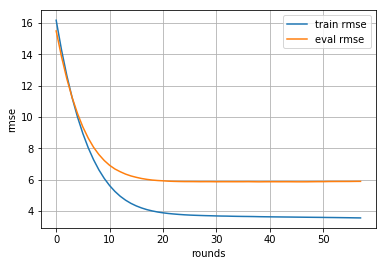

In [8]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

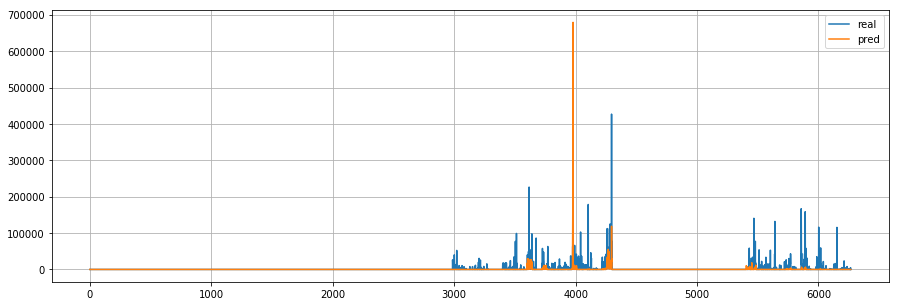

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesRyutsu'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

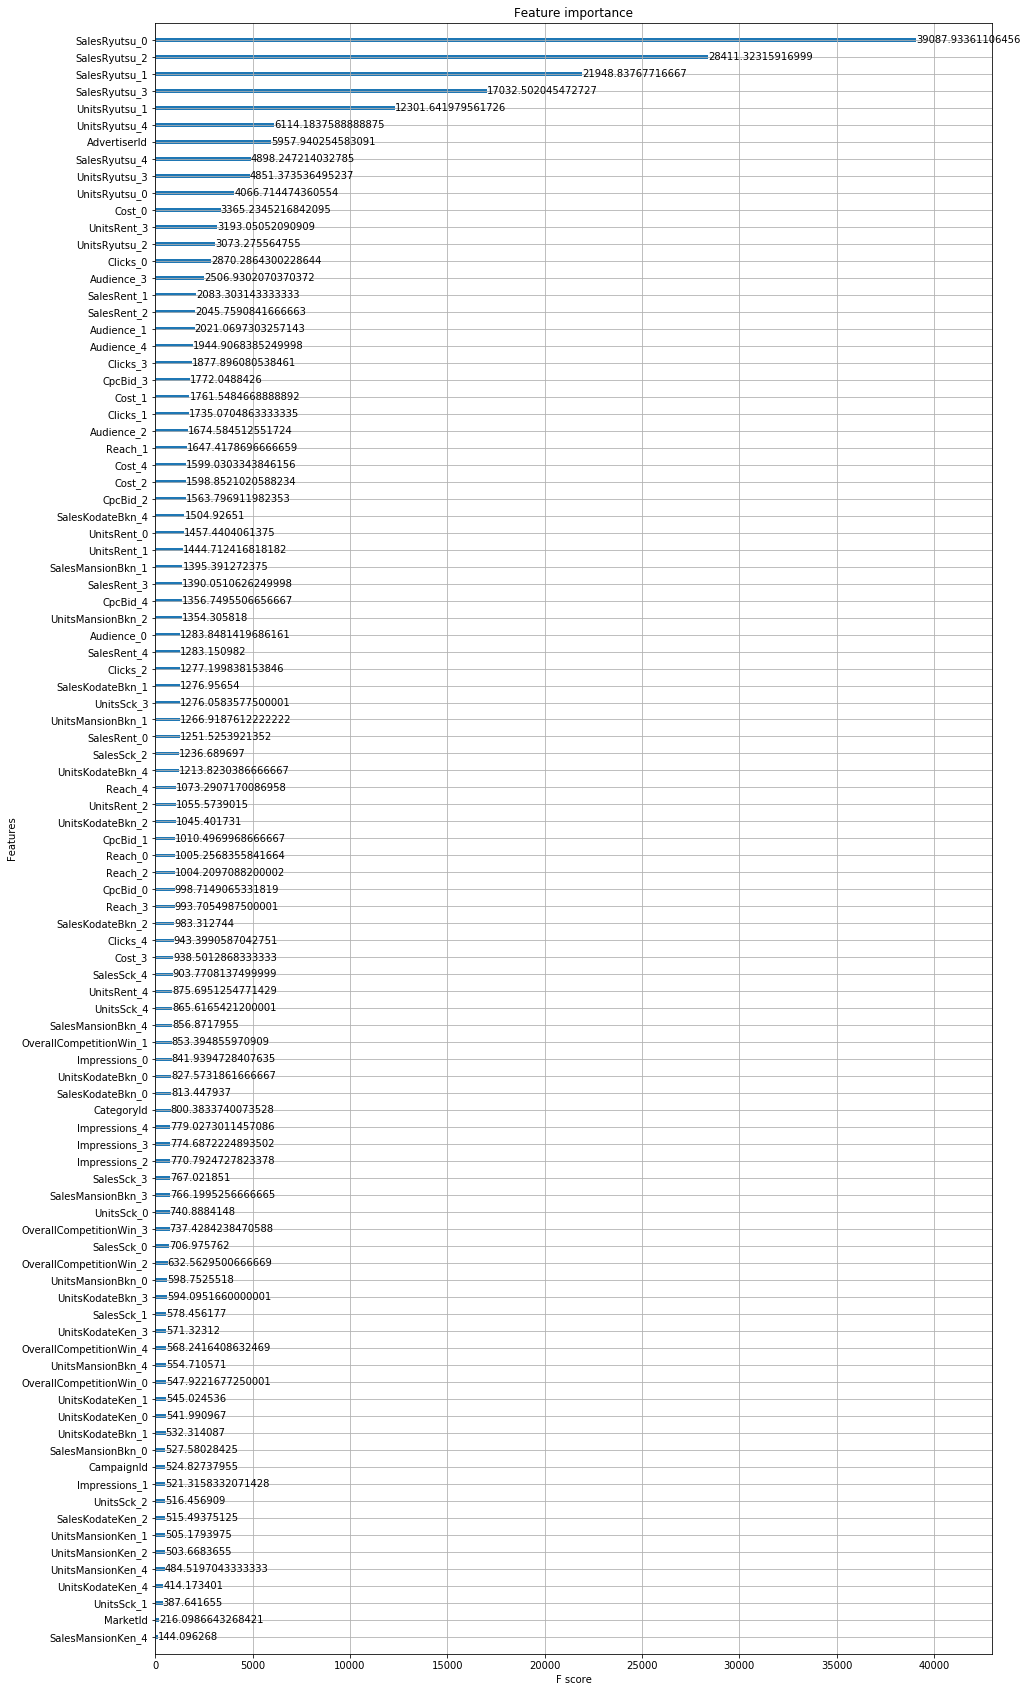

In [10]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [10]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesRyutsu_1',
 'SalesRyutsu_0',
 'SalesRyutsu_2',
 'AdvertiserId',
 'UnitsRyutsu_1',
 'UnitsRyutsu_2',
 'UnitsRyutsu_0',
 'SalesRyutsu_3',
 'Clicks_0',
 'UnitsRyutsu_4',
 'Cost_0',
 'Audience_4',
 'SalesRyutsu_4',
 'SalesKodateKen_0',
 'SalesRent_3',
 'SalesSck_4',
 'UnitsRent_3',
 'SalesRent_1',
 'SalesMansionBkn_1',
 'Cost_2',
 'SalesRent_2',
 'SalesRent_0',
 'CpcBid_3',
 'Cost_1',
 'Clicks_2',
 'CpcBid_4',
 'Audience_3',
 'SalesKodateBkn_3',
 'Audience_2',
 'Audience_1',
 'SalesMansionBkn_2',
 'Impressions_4',
 'SalesMansionBkn_3',
 'Clicks_4',
 'Reach_1',
 'UnitsRyutsu_3',
 'Cost_3',
 'UnitsRent_4',
 'SalesKodateBkn_2',
 'SalesKodateBkn_4',
 'SalesKodateKen_4',
 'SalesMansionBkn_4',
 'SalesSck_0',
 'CpcBid_2',
 'UnitsRent_2',
 'UnitsMansionBkn_1',
 'Cost_4',
 'SalesRent_4',
 'Clicks_3',
 'Clicks_1',
 'SalesSck_2',
 'UnitsKodateBkn_3',
 'Impressions_1',
 'Impressions_2',
 'Reach_4',
 'CpcBid_1',
 'Impressions_3',
 'UnitsSck_1',
 'SalesKodateBkn_1',
 'Reach_2',
 'UnitsRent_1',
 '